<a href="https://colab.research.google.com/github/meichenfang/Poisson-regression/blob/main/demos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation

In [1]:
%cd ..

# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

import Chronocell
print(Chronocell.__version__)

from Chronocell.inference import Trajectory
from Chronocell.mixtures import PoissonMixtureSS
from Chronocell.utils import *
from Chronocell.plotting import *

/home/mffang/workspace/Trajectory/FGP_2024
2024.10


In [2]:
import scipy.stats as stats
from sklearn.model_selection import StratifiedKFold
import anndata as ad
import velocyto as vcy
import scanpy as sc
import copy
from multiprocessing import Pool
import cmasher as cmr
import pickle
import tqdm

import warnings

# Suppress specific FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [12]:
plt.rcParams['font.size'] = '20'
plt.rcParams['lines.linewidth'] = 6
plt.rcParams['lines.markersize'] = 12
plt.rcParams['figure.constrained_layout.use'] = True
label_font = '36'
legend_font = '24'

# Generate clusters data

In [4]:
def simulate_static_data(n_states, n=10000, p=200, loga_mu=1, loga_sd=1, logb_mu=2, logb_sd=0.5, phi=0, random_seed=0, loomfilepath=None):    
    np.random.seed(random_seed)
    theta=np.zeros((p,n_states+2))
    for j in range(n_states):
        theta[:,j]=np.random.lognormal(loga_mu,loga_sd,size=p)
    theta[:,-2:]=np.random.lognormal(logb_mu,logb_sd,size=(p,2))
    theta[:,:n_states]/=theta[:,-2,None]
    theta[:,-1]/=np.exp(1.5)
           
    Y = np.zeros((n_states,p,2))
    Y[:,:,0]=theta[:,:n_states].T
    Y[:,:,1]=(theta[:,-2]/theta[:,-1])[None,:]*Y[:,:,0]

    idx = np.random.randint(0,n_states,size=n)
    Z = Y[idx]
    
    if phi > 0:
        Z *= np.random.gamma(shape=1/phi,scale=phi,size=(n,p,2))

    rd_mu, rd_var = 0.25, 0.25
    a = (1-rd_mu)/rd_var - rd_mu
    b = (1/rd_mu-1)*a
    rd = np.random.beta(a=a, b=b, size=n)
    X = np.random.poisson(rd[:,None,None]*Z)
    
    if loomfilepath is not None:
        adata=ad.AnnData(np.sum(X,axis=-1))
        adata.layers["spliced"] = X[:,:,1]
        adata.layers["unspliced"] = X[:,:,0]
        adata.layers["ambiguous"]=np.zeros_like(X[:,:,0])
        adata.obs["true_time"]=idx
        adata.obs["cell_type"]=idx
        adata.obs["read_depth"]=rd
        adata.uns["true_theta"]=theta
        adata.var["true_beta"]=theta[:,-2]
        adata.var["true_gamma"]=theta[:,-1]
        adata.write_loom(loomfilepath)

    return theta, idx, rd, Z, X,

# Chronocell

## Noise free data

In [5]:
true_theta, idx, rd, Y, X = simulate_static_data(4,n=10000,p=200,loomfilepath='data/sim_4_clusters.loom')

In [6]:
adata = sc.read('data/sim_4_clusters.loom')
n, p = adata.X.shape
X=np.zeros((n,p,2))
X[:,:,0]=adata.layers["unspliced"].toarray()
X[:,:,1]=adata.layers["spliced"].toarray()
print(X[:,:,0].mean(),X[:,:,1].mean())

true_time = adata.obs["true_time"]
rd = adata.obs["read_depth"]
adata

0.140598 0.682786


/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 10000 × 200
    obs: 'cell_type', 'obs_names', 'read_depth', 'true_time'
    var: 'true_beta', 'true_gamma', 'var_names'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

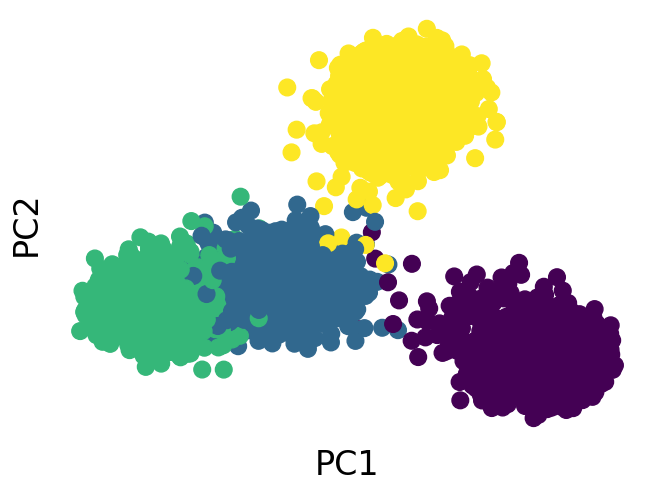

In [7]:
from sklearn.decomposition import PCA

total_UMI = adata.X.toarray().sum(axis=1)
r = total_UMI/np.mean(total_UMI)
pca = PCA(n_components=2)
x_pca = pca.fit_transform(np.log(1+adata.X.toarray()/total_UMI[:,None]*np.mean(total_UMI)))

fig, ax = plt.subplots(1,1)
ax.scatter(x_pca[:,0],x_pca[:,1],c=adata.obs['cell_type']);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

In [ ]:
topo = np.array([[0,1,2],[0,1,3]],dtype=int)
tau = np.array((0,1,2),dtype=float)
params = {'r':rd/rd.mean(),'bnd_beta':1e6}

Input_args = []
def fit_wrapper(seed):
    traj = Trajectory(topo, tau, model="two_species_ss", verbose=0)
    traj = traj.fit(X,m=100,n_init=1,params=params,perm_theta=False,epoch=100,parallel=False,n_threads=1,seed=seed)
    return traj
    
for seed in range(50):
    Input_args.append([seed])
            
with Pool(25) as pool:      
    trajs = pool.starmap(fit_wrapper, Input_args, chunksize=1)

In [13]:
with open('results/simulations_clusters/trajs.pickle', 'wb') as f:
    pickle.dump(trajs, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('results/simulations_clusters/trajs.pickle', 'rb') as f:
    trajs = pickle.load(f)

In [30]:
traj_ws = Trajectory(topo, tau, model="two_species_ss", verbose=2)
traj_ws = traj_ws.fit(X,warm_start=True,m=100,theta=true_theta,params=params,perm_theta=False,epoch=100,parallel=True,n_threads=4)

fitting with warm start


 20%|██        | 20/100 [01:04<03:39,  2.74s/it]

normalize Q 94 100
normalize Q 92 100


 21%|██        | 21/100 [01:08<04:19,  3.28s/it]

(global) tau = [0.         0.96969758 2.        ]
normalize Q 95 100
normalize Q 93 100


 22%|██▏       | 22/100 [01:13<04:59,  3.84s/it]

(global) tau = [0.         0.96969553 2.        ]
normalize Q 95 100
normalize Q 94 100


 23%|██▎       | 23/100 [01:18<05:17,  4.12s/it]

(global) tau = [0.         0.96969387 2.        ]
normalize Q 95 100
normalize Q 93 100


 24%|██▍       | 24/100 [01:23<05:30,  4.34s/it]

(global) tau = [0.         0.96969561 2.        ]
normalize Q 96 100
normalize Q 96 100


 25%|██▌       | 25/100 [01:28<05:38,  4.51s/it]

(global) tau = [0.         0.96969802 2.        ]
normalize Q 96 100
normalize Q 96 100


 26%|██▌       | 26/100 [01:32<05:26,  4.41s/it]

(global) tau = [0.         0.96969712 2.        ]
normalize Q 96 100
normalize Q 96 100


 27%|██▋       | 27/100 [01:36<05:18,  4.37s/it]

(global) tau = [0.         0.96969717 2.        ]
normalize Q 95 100
normalize Q 95 100


 28%|██▊       | 28/100 [01:41<05:19,  4.43s/it]

(global) tau = [0.         0.96969506 2.        ]
normalize Q 96 100
normalize Q 95 100


 29%|██▉       | 29/100 [01:45<05:18,  4.48s/it]

(global) tau = [0.        0.9696952 2.       ]
normalize Q 94 100
normalize Q 94 100


 30%|███       | 30/100 [01:50<05:17,  4.53s/it]

(global) tau = [0.         0.94949635 2.        ]
normalize Q 96 100
normalize Q 96 100


 31%|███       | 31/100 [01:55<05:14,  4.55s/it]

(global) tau = [0.         0.96969662 2.        ]
normalize Q 96 100
normalize Q 96 100


 32%|███▏      | 32/100 [01:59<05:01,  4.44s/it]

(global) tau = [0.         0.96969714 2.        ]
normalize Q 96 100
normalize Q 96 100


 33%|███▎      | 33/100 [02:03<04:48,  4.31s/it]

(global) tau = [0.         0.96969615 2.        ]
normalize Q 94 100
normalize Q 94 100


 34%|███▍      | 34/100 [02:08<04:52,  4.43s/it]

(global) tau = [0.         0.94949554 2.        ]
normalize Q 95 100
normalize Q 95 100


 35%|███▌      | 35/100 [02:13<04:58,  4.59s/it]

(global) tau = [0.         0.96969841 2.        ]
normalize Q 96 100
normalize Q 96 100


 36%|███▌      | 36/100 [02:17<04:58,  4.66s/it]

(global) tau = [0.         0.96969614 2.        ]
normalize Q 96 100
normalize Q 96 100


 37%|███▋      | 37/100 [02:22<04:45,  4.54s/it]

(global) tau = [0.         0.96969798 2.        ]
normalize Q 96 100
normalize Q 96 100


 38%|███▊      | 38/100 [02:26<04:33,  4.41s/it]

(global) tau = [0.         0.96969679 2.        ]
normalize Q 94 100
normalize Q 94 100


 39%|███▉      | 39/100 [02:30<04:32,  4.46s/it]

(global) tau = [0.         0.94949764 2.        ]
normalize Q 95 100
normalize Q 95 100


 40%|████      | 40/100 [02:35<04:29,  4.49s/it]

(global) tau = [0.         0.96969512 2.        ]
normalize Q 96 100
normalize Q 96 100


 41%|████      | 41/100 [02:40<04:28,  4.55s/it]

(global) tau = [0.         0.96969745 2.        ]
normalize Q 96 100
normalize Q 96 100


 42%|████▏     | 42/100 [02:44<04:17,  4.45s/it]

(global) tau = [0.         0.96969753 2.        ]
normalize Q 95 100
normalize Q 95 100


 43%|████▎     | 43/100 [02:49<04:18,  4.54s/it]

(global) tau = [0.         0.96969638 2.        ]
normalize Q 95 100
normalize Q 95 100


 44%|████▍     | 44/100 [02:53<04:11,  4.50s/it]

(global) tau = [0.         0.96969717 2.        ]
normalize Q 96 100
normalize Q 96 100


 45%|████▌     | 45/100 [02:57<04:02,  4.40s/it]

(global) tau = [0.         0.96969582 2.        ]
normalize Q 96 100
normalize Q 96 100


 46%|████▌     | 46/100 [03:01<03:50,  4.26s/it]

(global) tau = [0.         0.96969538 2.        ]
normalize Q 96 100
normalize Q 96 100


 47%|████▋     | 47/100 [03:05<03:40,  4.16s/it]

(global) tau = [0.         0.96969693 2.        ]
normalize Q 94 100
normalize Q 94 100


 48%|████▊     | 48/100 [03:10<03:44,  4.32s/it]

(global) tau = [0.         0.94949404 2.        ]
normalize Q 95 100
normalize Q 95 100


 49%|████▉     | 49/100 [03:14<03:45,  4.43s/it]

(global) tau = [0.         0.96969747 2.        ]
normalize Q 96 100
normalize Q 95 100


 50%|█████     | 50/100 [03:19<03:44,  4.49s/it]

(global) tau = [0.         0.96969637 2.        ]
normalize Q 96 100
normalize Q 96 100


 51%|█████     | 51/100 [03:23<03:36,  4.41s/it]

(global) tau = [0.         0.96969587 2.        ]
normalize Q 96 100
normalize Q 96 100


 52%|█████▏    | 52/100 [03:27<03:26,  4.31s/it]

(global) tau = [0.         0.96969687 2.        ]
normalize Q 94 100
normalize Q 94 100


 53%|█████▎    | 53/100 [03:32<03:25,  4.38s/it]

(global) tau = [0.         0.94949558 2.        ]
normalize Q 95 100
normalize Q 95 100


 54%|█████▍    | 54/100 [03:36<03:25,  4.46s/it]

(global) tau = [0.         0.96969485 2.        ]
normalize Q 96 100
normalize Q 96 100


 55%|█████▌    | 55/100 [03:41<03:20,  4.45s/it]

(global) tau = [0.         0.96969624 2.        ]
normalize Q 96 100
normalize Q 96 100


 56%|█████▌    | 56/100 [03:45<03:13,  4.40s/it]

(global) tau = [0.         0.96969696 2.        ]
normalize Q 96 100
normalize Q 96 100


 57%|█████▋    | 57/100 [03:49<03:05,  4.33s/it]

(global) tau = [0.         0.96969717 2.        ]
normalize Q 94 100
normalize Q 94 100


 58%|█████▊    | 58/100 [03:54<03:07,  4.47s/it]

(global) tau = [0.         0.94949601 2.        ]
normalize Q 95 100
normalize Q 95 100


 59%|█████▉    | 59/100 [03:59<03:05,  4.51s/it]

(global) tau = [0.         0.96969747 2.        ]
normalize Q 96 100
normalize Q 96 100


 60%|██████    | 60/100 [04:03<02:57,  4.44s/it]

(global) tau = [0.         0.96969705 2.        ]
normalize Q 96 100
normalize Q 96 100


 61%|██████    | 61/100 [04:07<02:51,  4.39s/it]

(global) tau = [0.        0.9696969 2.       ]
normalize Q 96 100
normalize Q 95 100


 62%|██████▏   | 62/100 [04:12<02:45,  4.36s/it]

(global) tau = [0.         0.96969564 2.        ]
normalize Q 96 100
normalize Q 96 100


 63%|██████▎   | 63/100 [04:15<02:33,  4.15s/it]

(global) tau = [0.         0.96969733 2.        ]
normalize Q 96 100
normalize Q 96 100


 64%|██████▍   | 64/100 [04:19<02:26,  4.07s/it]

(global) tau = [0.         0.96969589 2.        ]
normalize Q 94 100
normalize Q 94 100


 65%|██████▌   | 65/100 [04:24<02:26,  4.18s/it]

(global) tau = [0.         0.94949357 2.        ]
normalize Q 95 100
normalize Q 95 100


 66%|██████▌   | 66/100 [04:28<02:26,  4.32s/it]

(global) tau = [0.         0.96969713 2.        ]
normalize Q 95 100
normalize Q 95 100


 67%|██████▋   | 67/100 [04:32<02:20,  4.25s/it]

(global) tau = [0.         0.94949433 2.        ]
normalize Q 96 100
normalize Q 96 100


 68%|██████▊   | 68/100 [04:37<02:16,  4.27s/it]

(global) tau = [0.         0.96969746 2.        ]
normalize Q 96 100
normalize Q 96 100


 69%|██████▉   | 69/100 [04:41<02:10,  4.22s/it]

(global) tau = [0.         0.96969566 2.        ]
normalize Q 95 100
normalize Q 95 100


 70%|███████   | 70/100 [04:45<02:09,  4.30s/it]

(global) tau = [0.         0.96969745 2.        ]
normalize Q 95 100
normalize Q 95 100


 71%|███████   | 71/100 [04:50<02:06,  4.38s/it]

(global) tau = [0.         0.96969773 2.        ]
normalize Q 96 100
normalize Q 96 100


 72%|███████▏  | 72/100 [04:54<01:59,  4.26s/it]

(global) tau = [0.         0.96969764 2.        ]
normalize Q 96 100
normalize Q 96 100


 73%|███████▎  | 73/100 [04:58<01:52,  4.17s/it]

(global) tau = [0.         0.96969849 2.        ]
normalize Q 96 100
normalize Q 96 100


 74%|███████▍  | 74/100 [05:02<01:48,  4.16s/it]

(global) tau = [0.         0.96969591 2.        ]
normalize Q 94 100
normalize Q 94 100


 75%|███████▌  | 75/100 [05:06<01:46,  4.27s/it]

(global) tau = [0.         0.94949601 2.        ]
normalize Q 95 100
normalize Q 95 100


 76%|███████▌  | 76/100 [05:12<01:51,  4.64s/it]

(global) tau = [0.         0.96969586 2.        ]
normalize Q 96 100
normalize Q 96 100


 77%|███████▋  | 77/100 [05:19<02:01,  5.30s/it]

(global) tau = [0.         0.96969704 2.        ]
normalize Q 96 100
normalize Q 96 100


 78%|███████▊  | 78/100 [05:28<02:21,  6.44s/it]

(global) tau = [0.         0.96969609 2.        ]
normalize Q 96 100
normalize Q 96 100


 79%|███████▉  | 79/100 [05:37<02:31,  7.24s/it]

(global) tau = [0.         0.96969533 2.        ]
normalize Q 94 100
normalize Q 94 100


 80%|████████  | 80/100 [05:48<02:46,  8.32s/it]

(global) tau = [0.         0.94949486 2.        ]
normalize Q 95 100
normalize Q 95 100


 81%|████████  | 81/100 [05:59<02:53,  9.13s/it]

(global) tau = [0.         0.96969657 2.        ]
normalize Q 96 100
normalize Q 96 100


 82%|████████▏ | 82/100 [06:09<02:51,  9.53s/it]

(global) tau = [0.         0.96969587 2.        ]
normalize Q 96 100
normalize Q 96 100


 83%|████████▎ | 83/100 [06:20<02:46,  9.82s/it]

(global) tau = [0.         0.96969655 2.        ]
normalize Q 96 100
normalize Q 96 100


 84%|████████▍ | 84/100 [06:29<02:33,  9.62s/it]

(global) tau = [0.         0.96969748 2.        ]
normalize Q 94 100
normalize Q 94 100


 85%|████████▌ | 85/100 [06:40<02:30, 10.01s/it]

(global) tau = [0.         0.94949568 2.        ]
normalize Q 95 100
normalize Q 95 100


 86%|████████▌ | 86/100 [06:48<02:11,  9.39s/it]

(global) tau = [0.         0.96969699 2.        ]
normalize Q 96 100
normalize Q 96 100


 87%|████████▋ | 87/100 [06:58<02:05,  9.69s/it]

(global) tau = [0.         0.96969549 2.        ]
normalize Q 96 100
normalize Q 96 100


 88%|████████▊ | 88/100 [07:08<01:57,  9.79s/it]

(global) tau = [0.         0.96969729 2.        ]
normalize Q 96 100
normalize Q 96 100


 89%|████████▉ | 89/100 [07:18<01:46,  9.72s/it]

(global) tau = [0.         0.96969572 2.        ]
normalize Q 94 100
normalize Q 94 100


 90%|█████████ | 90/100 [07:28<01:39,  9.98s/it]

(global) tau = [0.         0.94949765 2.        ]
normalize Q 95 100
normalize Q 95 100


 91%|█████████ | 91/100 [07:39<01:30, 10.11s/it]

(global) tau = [0.         0.96969536 2.        ]
normalize Q 96 100
normalize Q 96 100


 92%|█████████▏| 92/100 [07:49<01:20, 10.04s/it]

(global) tau = [0.         0.96969581 2.        ]
normalize Q 96 100
normalize Q 96 100


 93%|█████████▎| 93/100 [07:59<01:11, 10.20s/it]

(global) tau = [0.         0.96969719 2.        ]
normalize Q 96 100
normalize Q 96 100


 94%|█████████▍| 94/100 [08:08<00:59,  9.88s/it]

(global) tau = [0.        0.9696962 2.       ]
normalize Q 94 100
normalize Q 94 100


 95%|█████████▌| 95/100 [08:19<00:51, 10.23s/it]

(global) tau = [0.         0.94949624 2.        ]
normalize Q 95 100
normalize Q 95 100


 96%|█████████▌| 96/100 [08:30<00:41, 10.37s/it]

(global) tau = [0.         0.96969589 2.        ]
normalize Q 96 100
normalize Q 96 100


 97%|█████████▋| 97/100 [08:40<00:30, 10.28s/it]

(global) tau = [0.         0.96969821 2.        ]
normalize Q 96 100
normalize Q 96 100


 98%|█████████▊| 98/100 [08:50<00:20, 10.27s/it]

(global) tau = [0.         0.96969805 2.        ]
normalize Q 96 100
normalize Q 96 100


 99%|█████████▉| 99/100 [09:00<00:09, 10.00s/it]

(global) tau = [0.         0.96969803 2.        ]
normalize Q 94 100
normalize Q 94 100


100%|██████████| 100/100 [09:11<00:00,  5.51s/it]

(global) tau = [0.         0.94949719 2.        ]


In [15]:
n,p = X.shape[:2]
theta0 = np.zeros((p,5))
theta0[:,:4] = traj.theta[:,:4]
theta0[:,4] = traj.theta[:,-2]/traj.theta[:,-1]

PMSS = PoissonMixtureSS(n_components=4,verbose=1)
Q, lower_bound = PMSS.fit(X, warm_start=True, theta=theta0, read_depth=rd/rd.mean(), n_init=10, epoch=10)
PMSS.Q = Q
PMSS.elbo = lower_bound

/home/mffang/workspace/Trajectory/FGP_2024/Chronocell/mixtures.py:85: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  logL = np.sum(poisson.logpmf(k=X[:,:,:,None], mu=self.rd[:,None,None,None] * self.theta[None,:,None,:self.n_components] * gamma[None,:,:,None]), axis=(1,2))
  0%|          | 0/10 [00:00<?, ?it/s]/home/mffang/workspace/Trajectory/FGP_2024/Chronocell/mixtures.py:78: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  self.theta[:,:self.n_components] /= (Q[:,None,None,:]*self.rd[:,None,None,None]*gamma[None,:,:,None]).sum(axis=(0,2))
100%|██████████| 10/10 [00:27<00:00,  2.79s/it]


### AIC

In [35]:
weights = np.zeros_like(traj_ws.Q)
weights[:,:,0] = traj_ws.Q.mean(0).sum(0)[0]
weights[:,:,1:] = traj_ws.Q.mean(0).sum(0)[1:].mean()
weights[:,0] *= traj_ws.Q.mean(0).sum(1)[0]
weights[:,1] *= traj_ws.Q.mean(0).sum(1)[1]
traj_ws.weights = weights

In [36]:
corrs = []
AICs = []

for traj in trajs:
    weights = np.zeros_like(traj.Q)
    weights[:,:,0] = traj.Q.mean(0).sum(0)[0]
    weights[:,:,1:] = traj.Q.mean(0).sum(0)[1:].mean()
    weights[:,0] *= traj.Q.mean(0).sum(1)[0]
    weights[:,1] *= traj.Q.mean(0).sum(1)[1]
    traj.weights = weights
    AICs.append( traj.compute_AIC(traj.X, standard=True) )
    
traj = trajs[np.argmin(AICs)]
right_t = traj.Q.sum(1) @ traj.t
for traj_ in trajs:
    t_hat = traj_.Q.sum(1) @ traj_.t
    corrs.append(stats.pearsonr(right_t,t_hat)[0])

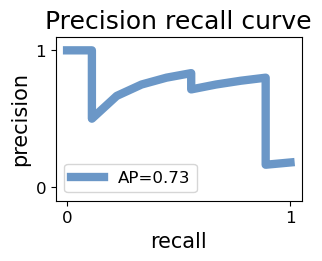

In [37]:
plt.rcParams['font.size'] = '12'

from sklearn.metrics import average_precision_score, precision_recall_curve

fig, ax = plt.subplots(1,1,figsize=(3,2.5))
is_correct_direction = np.array(np.array(corrs)>0.8,dtype=bool)
corrs_ratio = np.mean(is_correct_direction)
precision, recall, thresholds = precision_recall_curve(y_true=is_correct_direction,probas_pred=-np.array(AICs))
score = average_precision_score(y_true=is_correct_direction, y_score=-np.array(AICs))
plt.plot(recall, precision,'-',color='#3975b5',alpha=0.75,label="AP="+str(np.around(score,2)))
plt.ylim([-0.1,1.1])
plt.legend(fontsize=12)
plt.ylabel('precision',fontsize=15)
plt.xlabel('recall',fontsize=15)
plt.title('Precision recall curve',fontsize=18)

plt.rcParams['font.size'] = '24'

ValueError: x and y must be the same size

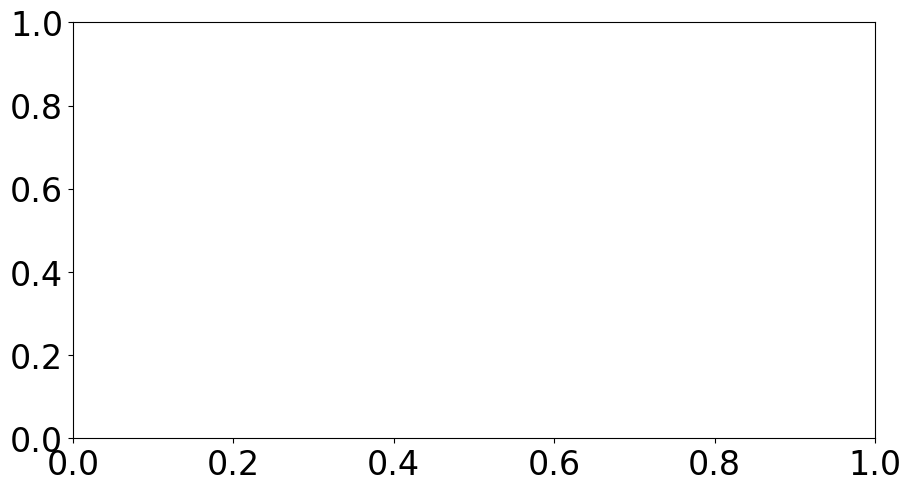

In [64]:
fig, ax = plt.subplots(1,1,figsize=(9,4.8))
plt.scatter(corrs,np.array(AICs),s=1000,marker='.',color='#3975b5',alpha=0.5,label='random init\nAP='+str(np.around(score,2)))
plt.axhline(PMSS.compute_AIC(X, standard=True),color='#dca36a',linewidth=12,zorder=0,alpha=0.5,label='4 clusters')
plt.axhline(traj_ws.compute_AIC(traj_ws.X, standard=True),color='#e07a5f',linewidth=12,zorder=0,alpha=0.5,label='warm start')
#ax.set_yticks([])
ax.set_xlim([-1.1,1.1])
#plt.xlabel('Correlation between inferred\ntime and warm start result',fontsize=label_font)
#plt.ylabel('ELBO',fontsize=label_font)
plt.legend(loc=(1.01,0.01),fontsize=legend_font)
#plt.title('ELBO of different initialiazations',fontsize=30)

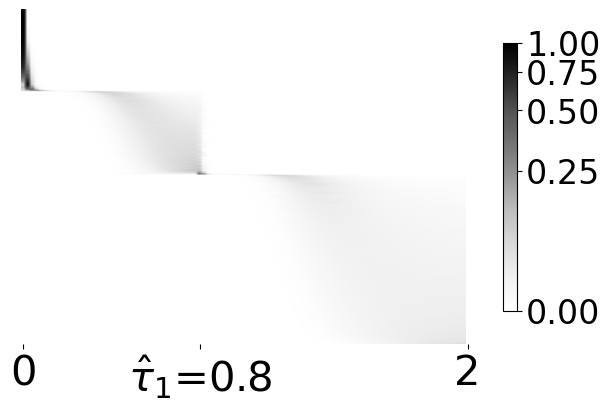

In [27]:
import matplotlib.colors as colors
def _forward(x):
    return np.log(0.1+x)

def _inverse(x):
    return np.exp(x)-0.1

norm = colors.FuncNorm((_forward, _inverse), vmin=0, vmax=1)

plt.rcParams['font.size'] = '24'

t_hat=traj.Q[:,0,:]@traj.t+traj.Q[:,1,:]@traj.t
cell_idx = np.argsort(t_hat)
Z = traj.Q[cell_idx,0,:] + traj.Q[cell_idx,1,:]

fig, ax = plt.subplots(1,1,figsize=(6,4))
cmap_Q = cmr.get_sub_cmap('Greys', 0.1, 1)

im = ax.imshow(Z,aspect="auto",cmap='Greys', norm=norm);

plt.colorbar(im,fraction=0.2, shrink =0.8) # adding the colobar on the right
x_label_list = ['0', r'$\hat{\tau}_1$='+str(np.around(traj.tau[1],1)), '2']
ax.set_xticks(traj.m*traj.tau/traj.tau[-1])
ax.set_xticklabels(x_label_list,fontsize=30)
ax.set_yticks([])
for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(False)

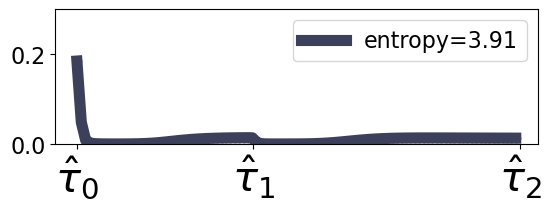

In [28]:
plt.rcParams['font.size'] = '16'
fig,ax = plt.subplots(figsize=(5.4,2))
ax.plot(traj.Q.sum((0,1))/traj.Q.sum(),'.-',color="#3d405b",linewidth=8,\
        label="entropy="+str(np.around(stats.entropy(traj.Q.sum((0,1))/traj.Q.sum()),2)));
x_label_list = [r'$\hat{\tau}_0$', r'$\hat{\tau}_1$', r'$\hat{\tau}_2$']
ax.set_xticks(traj.m*traj.tau/traj.tau[-1])
ax.set_xticklabels(x_label_list,fontsize=30)
ax.set_ylim([0,0.3])
ax.legend()
plt.rcParams['font.size'] = '24'

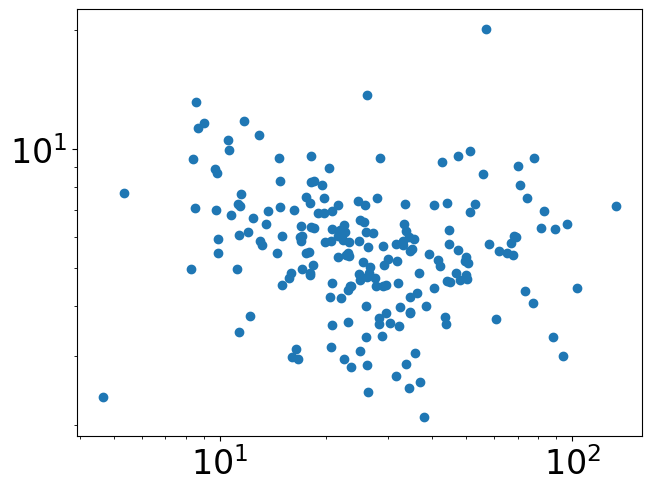

In [29]:
plt.loglog(traj.theta[:,-2],traj.theta[:,-1],'.')

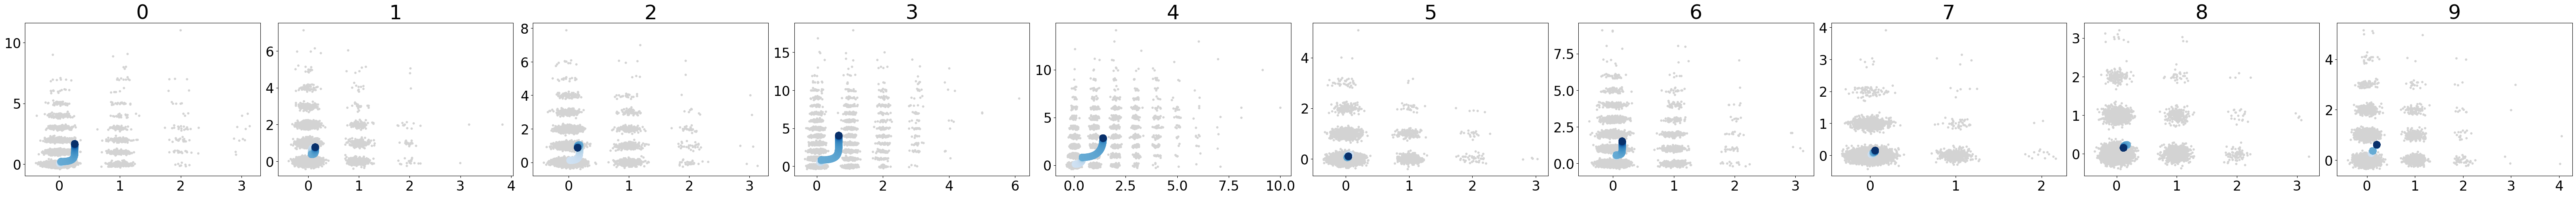

In [21]:
plot_phase(traj,idx=np.arange(10));

Text(0, 0.5, 'values')

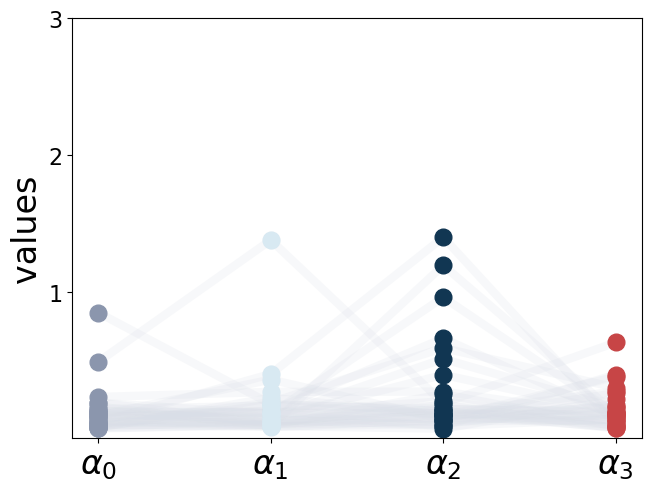

In [22]:
p = X.shape[1]
fig,ax = plt.subplots(1,1)
p_ = 30
for j in range(p_):
    ax.plot(traj.theta[j,[0,1,2,3]],'o-',color='#d9dee7',alpha=0.2)

colors=['#8b96ad','#d8e9f2','#113652','#c74546']
for j in range(4):
    ax.plot([j]*p_,traj.theta[:p_,j],'o',color=colors[j])
    

x_label_list = [r'$α_0$', r'$α_1$', r'$α_2$', r'$α_3$']
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(x_label_list,fontsize=24)

y_label_list = [1,2,3]
ax.set_yticks([1,2,3])
ax.set_yticklabels(y_label_list,fontsize=16)
ax.set_ylabel('values',fontsize=24)

### Model selection on 20 more samples

In [20]:
topo = np.array([[0,1,2],[0,1,3]],dtype=int)
tau = np.array((0,1,2),dtype=float)

Input_args = []

def fit_wrapper(seed):
    true_theta, idx, rd, Y, X_ = simulate_static_data(4,n=10000,p=200,random_seed=seed)
    r = rd/rd.mean()
    traj = Trajectory(topo, tau, model="two_species_ss", verbose=0)
    traj = traj.fit(X_,warm_start=False,params={'r':r,'bnd_beta':1e6},n_init=20, epoch=100, parallel=False)
    traj.true_theta = true_theta.copy()

    PMSS = PoissonMixtureSS(n_components=4)
    Q, lower_bound = PMSS.fit(X_, warm_start=False, read_depth=r, n_init=10, epoch=10)
    
    return (PMSS,traj)
    
for seed in range(20):
    Input_args.append([seed])
            
with Pool(20) as pool:      
    models = pool.starmap(fit_wrapper, Input_args, chunksize=1)

with open('results/simulations_clusters/models.pickle', 'wb') as f:
    pickle.dump(models, f, pickle.HIGHEST_PROTOCOL)

In [30]:
with open('results/simulations_clusters/models.pickle', 'rb') as f:
    models = pickle.load(f)
    
AICs = []
PMSS_AICs = []

for model in tqdm.tqdm(models):
    PMSS,traj = model
    PMSS_AICs.append( PMSS.compute_AIC(traj.X,standard=True) )
    #weights = np.ones(traj.m)
    #weights[0] = traj.Q.mean(0).sum(0)[0]
    #weights[1:] = traj.Q.mean(0).sum(0)[1:].mean()
    #traj.weights = weights
    AICs.append( traj.compute_AIC(traj.X,standard=True) )
AICs = np.array(AICs)
PMSS_AICs = np.array(PMSS_AICs)

100%|██████████| 20/20 [00:17<00:00,  1.14it/s]


(array([ 0.,  0.,  0.,  0.,  0., 20.,  0.,  0.,  0.,  0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

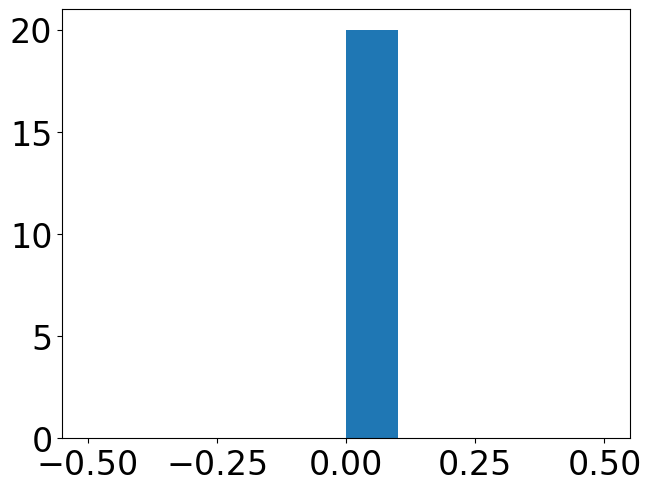

In [31]:
model = [np.argmin([PMSS_AICs[i],AICs[i]]) for i in range(20)]
plt.hist(model)

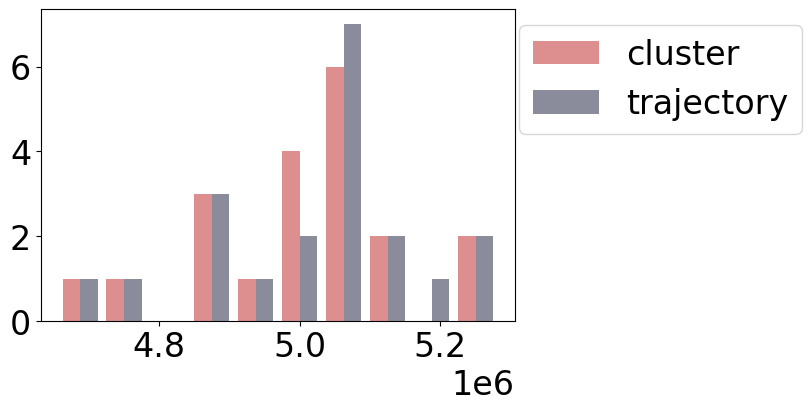

In [32]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
base = np.minimum(np.min(PMSS_AICs),np.min(AICs))
bins = np.linspace(np.minimum(np.min(PMSS_AICs),np.min(AICs)),np.maximum(np.max(PMSS_AICs),np.max(AICs)),11)
ax.hist([PMSS_AICs,AICs],color=['#c74546','#3d405b'],alpha=0.6,label=['cluster','trajectory'],bins=bins)
ax.legend(loc=(1.01,0.6),fontsize=legend_font);

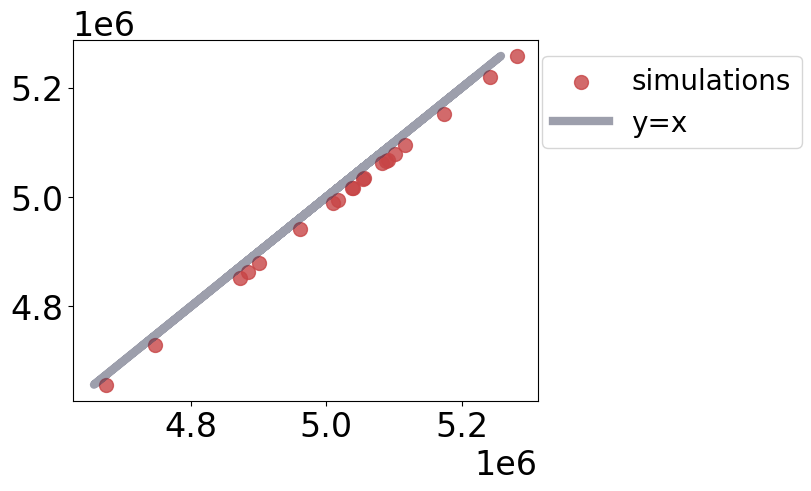

In [41]:
fig, ax = plt.subplots(1,1,figsize=(8,4.8))
ax.scatter(AICs,PMSS_AICs,color='#c74546',alpha=0.8,s=100,label='simulations')
ax.plot(PMSS_AICs,PMSS_AICs,'#3d405b',alpha=0.5,linewidth=6,label='y=x')
ax.legend(loc=(1.01,0.7),fontsize=20);

In [43]:
from tqdm import tqdm

x = []
y = []
z = []
for model in tqdm(models):
    PMSS,traj = model
    AIC = []
    BIC = []
    ELBO = []
    
    AIC.append(PMSS.compute_AIC(traj.X,standard=True))
    BIC.append(PMSS.compute_BIC(traj.X,standard=True))
    ELBO.append(PMSS.compute_lower_bound(traj.X))
    
    AIC.append(traj.compute_AIC(traj.X,standard=True))
    BIC.append(traj.compute_BIC(traj.X,standard=True))
    ELBO.append(traj.compute_lower_bound(traj.X))

    x.append(np.argmin(AIC))
    y.append(np.argmin(BIC))
    z.append(np.argmax(ELBO))

100%|██████████| 20/20 [00:52<00:00,  2.64s/it]


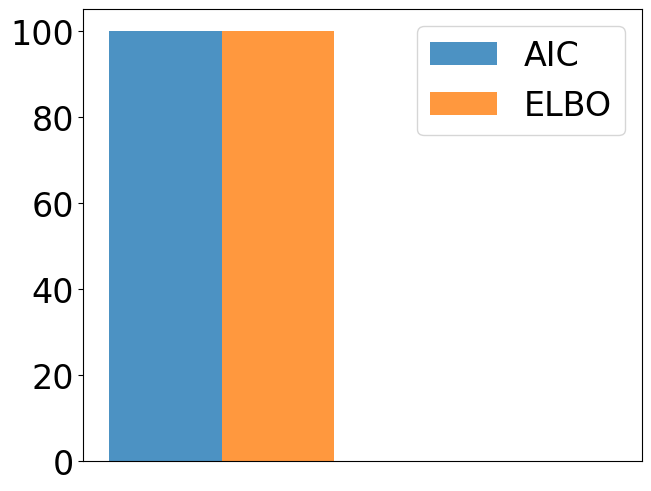

In [603]:
fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.hist([x,z],label=["AIC","ELBO"],bins=np.arange(3)-0.5,alpha=0.8)#,color=['#233d4d','#fe7f2d']
x_label_list = ['4 clusters', 'trajectory']
#ax.set_xticks([0,1])
#ax.set_xticklabels(x_label_list,fontsize=label_font);
ax.set_xticks([])
ax.legend(fontsize=legend_font)

In [76]:
logL_out = []
for traj in trajs:
    traj.params['r'] = rd[test_index]/rd[train_index].mean()
    logL_out.append( traj.compute_lower_bound(X_test) )
logL_out = np.array(logL_out)

In [64]:
topo = np.array([[0,1]],dtype=int)
tau = np.array((0,1),dtype=float)

trajs=[]
logL_out=[]
skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
for i, (train_index, test_index) in enumerate(skf.split(np.zeros(n), np.zeros(n))):
    X_train = X[train_index]
    X_test = X[test_index]
    params = {'r':rd[train_index]/rd[train_index].mean()}
    traj = Trajectory(topo, tau, model="two_species_ss", verbose=1)
    traj = traj.fit(X_train,m=100,n_init=1,params=params,perm_theta=False,epoch=100,parallel=False,n_threads=1)
    trajs.append(traj)
    traj.params['r'] = rd[test_index]/rd[train_index].mean()
    logL_out.append( traj.compute_lower_bound(X_test) )

Reminder: provide genewise unspliced to spliced capture rate ratio in params with key Ub
fitting with multiple random initializations
trial 1


100%|██████████| 100/100 [03:10<00:00,  1.90s/it]


Reminder: provide genewise unspliced to spliced capture rate ratio in params with key Ub
fitting with multiple random initializations
trial 1


100%|██████████| 100/100 [03:11<00:00,  1.91s/it]


Reminder: provide genewise unspliced to spliced capture rate ratio in params with key Ub
fitting with multiple random initializations
trial 1


100%|██████████| 100/100 [03:20<00:00,  2.01s/it]


Reminder: provide genewise unspliced to spliced capture rate ratio in params with key Ub
fitting with multiple random initializations
trial 1


100%|██████████| 100/100 [03:22<00:00,  2.03s/it]


Reminder: provide genewise unspliced to spliced capture rate ratio in params with key Ub
fitting with multiple random initializations
trial 1


100%|██████████| 100/100 [02:54<00:00,  1.75s/it]


In [9]:
logL_out_PM=[]
for i, (train_index, test_index) in enumerate(skf.split(np.zeros(n), np.zeros(n))):
    X_train = X[train_index]
    X_test = X[test_index]
    PMSS = PoissonMixtureSS(n_components=3)
    Q, lower_bound = PMSS.fit(X_train, warm_start=False, read_depth=rd[train_index]/rd[train_index].mean(), n_init=5, epoch=10)
    PMSS.rd = rd[test_index]/rd[train_index].mean()
    logL_out_PM.append(PMSS.compute_lower_bound(X_test))

NameError: name 'skf' is not defined

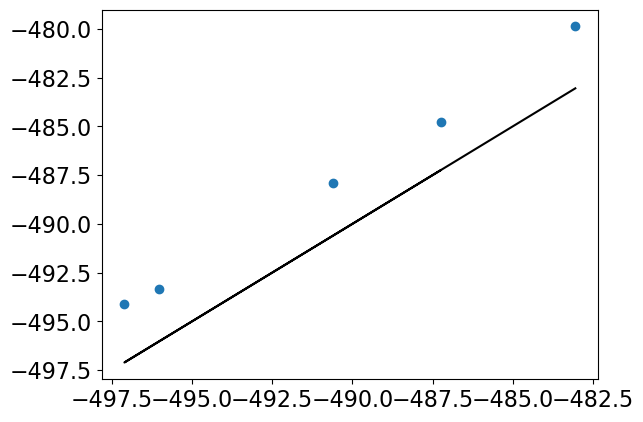

In [89]:
plt.plot(logL_out_PM,logL_out_PM,'k')
plt.scatter(logL_out_PM,logL_out)

In [9]:
topo = np.array([[0,1]],dtype=int)
tau = np.array((0,1),dtype=float)
params = {'r':rd[train_index]/rd[train_index].mean()}

Input_args = []
def fit_wrapper(seed):
    traj = Trajectory(topo, tau, model="two_species_ss", verbose=0)
    traj = traj.fit(X_train,m=100,n_init=1,params=params,perm_theta=False,epoch=100,parallel=False,n_threads=1,seed=seed)
    return traj
    
for seed in range(100):
    Input_args.append([seed])
            
with Pool(50) as pool:      
    trajs = pool.starmap(fit_wrapper, Input_args, chunksize=1)

NameError: name 'train_index' is not defined

### Bootstrap 100 times

In [29]:
topo = np.array([[0,1,2],[0,1,3]],dtype=int)
tau = np.array((0,1,2),dtype=float)
r = rd/rd.mean()

Input_args = []
def fit_wrapper(seed):
    np.random.seed(seed)
    bootstrap_idx = np.random.choice(n, size=n, replace=True)
    X_b = X[bootstrap_idx]

    params_b={'r':rd[bootstrap_idx],"lambda_tau":0,"lambda_a":0}

    traj = Trajectory(topo, tau, model="two_species_ss", verbose=0)
    traj = traj.fit(X_b,m=100,n_init=20,params=params_b,perm_theta=False,epoch=100,parallel=False,n_threads=1)
    return (bootstrap_idx,traj)
    
for seed in range(100):
    Input_args.append([seed])
            
with Pool(50) as pool:      
    bootstraps = pool.starmap(fit_wrapper, Input_args, chunksize=1)    

with open('results/negative_bs.pickle', 'wb') as f:
    pickle.dump(bootstraps, f, pickle.HIGHEST_PROTOCOL)

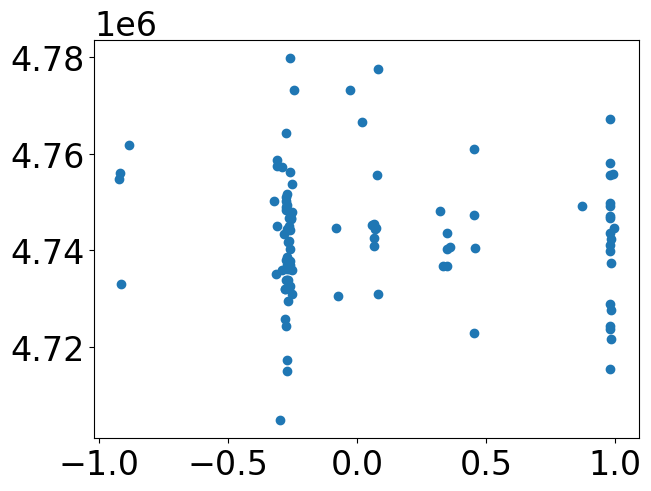

In [51]:
corrs_b = []
AICs = []

for bootstrap_idx,traj in bootstraps:
    ref_t = right_t[bootstrap_idx]
    t_hat = traj.Q.sum(1) @ traj.t
    corrs_b.append(stats.pearsonr(ref_t,t_hat)[0])
    AICs.append( traj.compute_AIC(traj.X, standard=True) )  
    
plt.plot(corrs_b,AICs,'.');

## Noisy data

In [59]:
true_theta, idx, rd, Y, X = simulate_static_data(4,n=10000,p=200,phi=1,loga_mu=1,random_seed=0,loomfilepath='data/simulation_4_clusters_noisy.loom')

In [18]:
adata = sc.read('data/simulation_4_clusters_noisy.loom')
n, p = adata.X.shape
X=np.zeros((n,p,2))
X[:,:,0]=adata.layers["unspliced"].toarray()
X[:,:,1]=adata.layers["spliced"].toarray()
print(X[:,:,0].mean(),X[:,:,1].mean())

true_time = adata.obs["true_time"]
rd = adata.obs["read_depth"]
adata

0.1425635 0.6941025


/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 10000 × 200
    obs: 'cell_type', 'obs_names', 'read_depth', 'true_time'
    var: 'true_beta', 'true_gamma', 'var_names'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

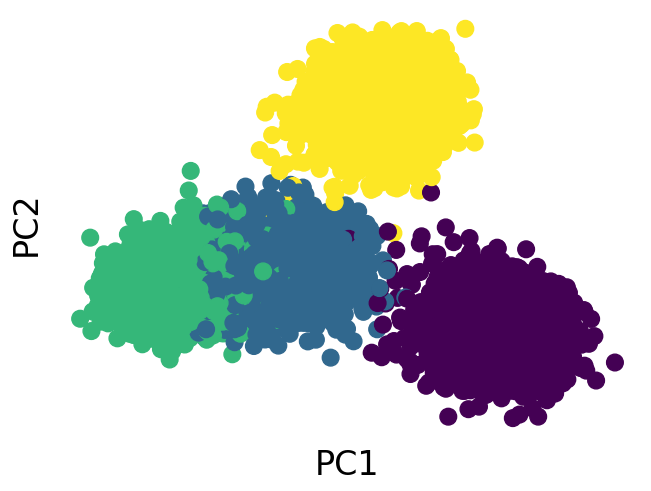

In [82]:
from sklearn.decomposition import PCA

total_UMI = adata.X.toarray().sum(axis=1)
r = total_UMI/np.mean(total_UMI)
pca = PCA(n_components=2)
x_pca = pca.fit_transform(np.log(1+adata.X.toarray()/total_UMI[:,None]*np.mean(total_UMI)))

fig, ax = plt.subplots(1,1)
ax.scatter(x_pca[:,0],x_pca[:,1],c=adata.obs['cell_type']);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

### Random initializations

In [ ]:
topo = np.array([[0,1,2],[0,1,3]],dtype=int)
tau = np.array((0,1,2),dtype=float)
params = {'r':rd/rd.mean()}

Input_args = []
def fit_wrapper(seed):
    traj = Trajectory(topo, tau, model="two_species_ss", verbose=0)
    traj = traj.fit(X,m=100,n_init=1,params=params,perm_theta=False,epoch=100,parallel=False,n_threads=1,seed=seed)
    return traj
    
for seed in range(100):
    Input_args.append([seed])
            
with Pool(50) as pool:      
    trajs = pool.starmap(fit_wrapper, Input_args, chunksize=1)

with open('results/clusters/noisy_clusters_ri.pickle', 'wb') as f:
    pickle.dump(trajs, f, pickle.HIGHEST_PROTOCOL)

In [75]:
with open('results/clusters/noisy_clusters_ri.pickle', 'rb') as f:
    trajs = pickle.load(f)

In [76]:
topo = np.array([[0,1,2],[0,1,3]],dtype=int)
tau = np.array((0,1,2),dtype=float)

corrs = []
AICs = []
K = len(tau)-1
for traj in trajs:
    weights = np.zeros_like(traj.Q)
    weights[:,:,0] = traj.Q.mean(0).sum(0)[0]
    weights[:,:,1:] = traj.Q.mean(0).sum(0)[1:].mean()
    weights[:,0] *= traj.Q.mean(0).sum(1)[0]
    weights[:,1] *= traj.Q.mean(0).sum(1)[1]
    traj.weights = weights
    AICs.append( traj.compute_AIC(traj.X, standard=True) )
    
traj = trajs[np.argmin(AICs)]
right_t = traj.Q[:,0] @ traj.t
for traj_ in trajs:
    t_hat = traj_.Q[:,0] @ traj_.t
    corrs.append(stats.pearsonr(right_t,t_hat)[0])

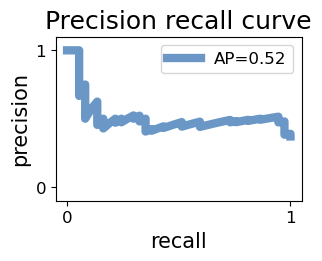

In [112]:
plt.rcParams['font.size'] = '12'

from sklearn.metrics import average_precision_score, precision_recall_curve

fig, ax = plt.subplots(1,1,figsize=(3,2.5))
is_correct_direction = np.array(np.array(corrs)>0.8,dtype=bool)
corrs_ratio = np.mean(is_correct_direction)
precision, recall, thresholds = precision_recall_curve(y_true=is_correct_direction,probas_pred=-np.array(AICs))
score = average_precision_score(y_true=is_correct_direction, y_score=-np.array(AICs))
plt.plot(recall, precision,'-',color='#3975b5',alpha=0.75,label="AP="+str(np.around(score,2)))
plt.ylim([-0.1,1.1])
plt.legend(fontsize=12)
plt.ylabel('precision',fontsize=15)
plt.xlabel('recall',fontsize=15)
plt.title('Precision recall curve',fontsize=18)

plt.rcParams['font.size'] = '24'

In [84]:
n,p = X.shape[:2]
theta0 = np.zeros((p,5))
theta0[:,:4] = traj.theta[:,:4]
theta0[:,4] = traj.theta[:,-2]/traj.theta[:,-1]

PMSS = PoissonMixtureSS(n_components=4,verbose=1)
Q, lower_bound = PMSS.fit(X, warm_start=True, theta=theta0, read_depth=rd/rd.mean(), epoch=10)
PMSS.Q = Q
PMSS.elbo = lower_bound

read_depth is not normalized


100%|██████████| 10/10 [00:15<00:00,  1.52s/it]


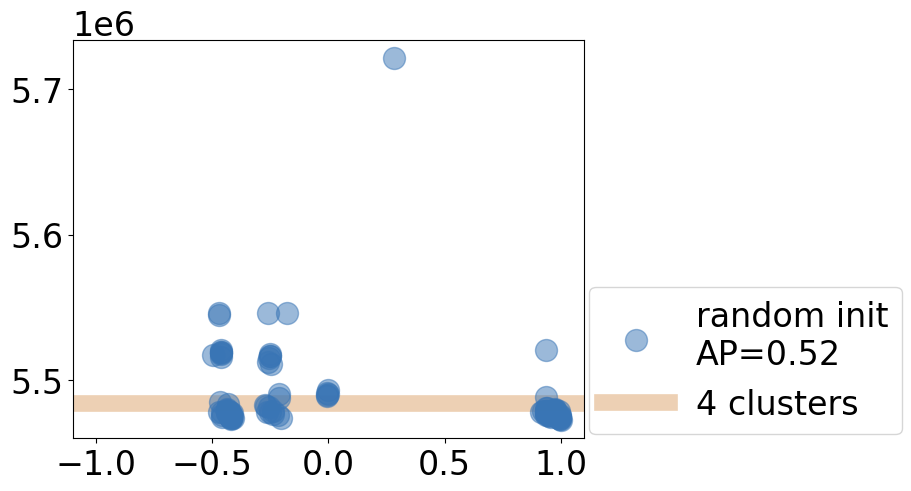

In [92]:
fig, ax = plt.subplots(1,1,figsize=(9,4.8))
plt.scatter(corrs,np.array(AICs),s=1000,marker='.',color='#3975b5',alpha=0.5,label='random init\nAP='+str(np.around(score,2)))
plt.axhline(PMSS.compute_AIC(X, standard=True),color='#dca36a',linewidth=12,zorder=0,alpha=0.5,label='4 clusters')
#ax.set_yticks([])
ax.set_xlim([-1.1,1.1])
#plt.xlabel('Correlation between inferred\ntime and warm start result',fontsize=label_font)
#plt.ylabel('ELBO',fontsize=label_font)
plt.legend(loc=(1.01,0.01),fontsize=legend_font)
#plt.title('ELBO of different initialiazations',fontsize=30)

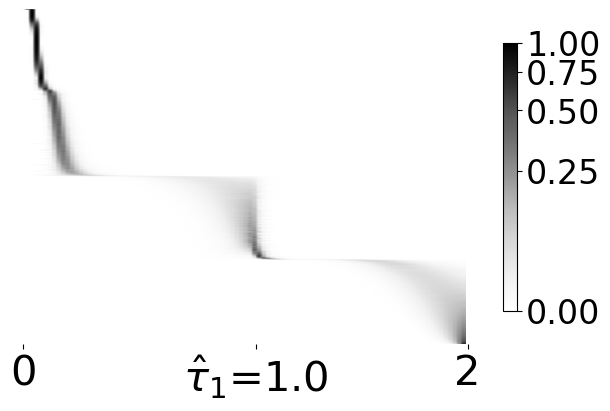

In [209]:
import matplotlib.colors as colors
def _forward(x):
    return np.log(0.1+x)

def _inverse(x):
    return np.exp(x)-0.1

norm = colors.FuncNorm((_forward, _inverse), vmin=0, vmax=1)

plt.rcParams['font.size'] = '24'

t_hat=traj.Q[:,0,:]@traj.t+traj.Q[:,1,:]@traj.t
cell_idx = np.argsort(t_hat)
Z = traj.Q[cell_idx,0,:] + traj.Q[cell_idx,1,:]

fig, ax = plt.subplots(1,1,figsize=(6,4))
cmap_Q = cmr.get_sub_cmap('Greys', 0.1, 1)

im = ax.imshow(Z,aspect="auto",cmap='Greys', norm=norm);

plt.colorbar(im,fraction=0.2, shrink =0.8) # adding the colobar on the right
x_label_list = ['0', r'$\hat{\tau}_1$='+str(np.around(traj.tau[1],1)), '2']
ax.set_xticks(traj.m*traj.tau/traj.tau[-1])
ax.set_xticklabels(x_label_list,fontsize=30)
ax.set_yticks([])
for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(False)

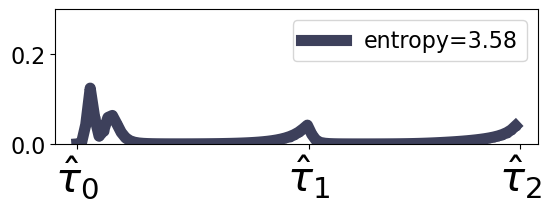

In [210]:
plt.rcParams['font.size'] = '16'
fig,ax = plt.subplots(figsize=(5.4,2))
ax.plot(traj.Q.sum((0,1))/traj.Q.sum(),'.-',color="#3d405b",linewidth=8,\
        label="entropy="+str(np.around(stats.entropy(traj.Q.sum((0,1))/traj.Q.sum()),2)));
x_label_list = [r'$\hat{\tau}_0$', r'$\hat{\tau}_1$', r'$\hat{\tau}_2$']
ax.set_xticks(traj.m*traj.tau/traj.tau[-1])
ax.set_xticklabels(x_label_list,fontsize=30)
ax.set_ylim([0,0.3])
ax.legend()
plt.rcParams['font.size'] = '24'

### Model selection on 20 more samples

In [81]:
topo = np.array([[0,1,2],[0,1,3]],dtype=int)
tau = np.array((0,1,2),dtype=float)
r = rd/rd.mean()
params = {'r':r}

Input_args = []

def fit_wrapper(seed):
    np.random.seed(seed)
    X_ = np.random.poisson(rd[:,None,None]*Y)
    
    traj = Trajectory(topo, tau, model="two_species_ss", verbose=0)
    traj = traj.fit(X_,warm_start=False,params=params,n_init=20, epoch=100, parallel=False)
    traj.true_theta = true_theta.copy()
    traj.true_time = idx.copy()

    PMSS = PoissonMixtureSS(n_components=4)
    Q, lower_bound = PMSS.fit(X_, warm_start=False, read_depth=r, n_init=10, epoch=10)
    
    return (PMSS,traj)
    
for seed in range(20):
    Input_args.append([seed])
            
with Pool(20) as pool:      
    models = pool.starmap(fit_wrapper, Input_args, chunksize=1)

with open('results/negative_noisy_models.pickle', 'wb') as f:
    pickle.dump(models, f, pickle.HIGHEST_PROTOCOL)

In [82]:
AICs = []
PMSS_AICs = []

for model in tqdm.tqdm(models):
    PMSS,traj = model
    PMSS_AICs.append( PMSS.compute_AIC(traj.X,standard=True) )
    weights = np.ones(traj.m)
    weights[0] = traj.Q.mean(0).sum(0)[0]
    weights[1:] = traj.Q.mean(0).sum(0)[1:].mean()
    traj.weights = weights
    AICs.append( traj.compute_AIC(traj.X,standard=True) )
AICs = np.array(AICs)
PMSS_AICs = np.array(PMSS_AICs)

100%|██████████| 20/20 [00:22<00:00,  1.13s/it]


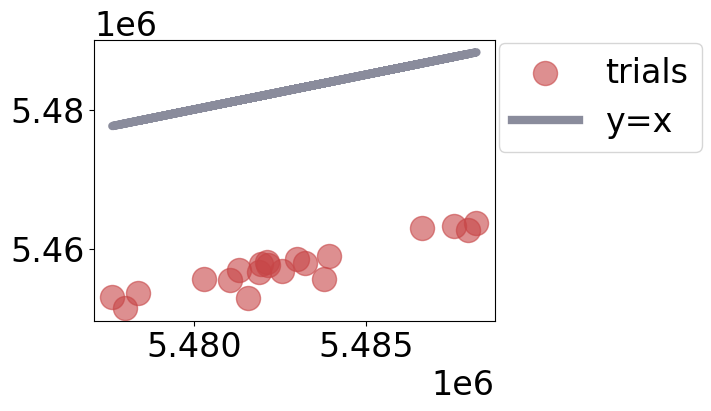

In [83]:
fig, ax = plt.subplots(1,1,figsize=(7,4))
ax.scatter(PMSS_AICs,AICs,color='#c74546',alpha=0.6,s=300,label='trials')
ax.plot(PMSS_AICs,PMSS_AICs,'#3d405b',alpha=0.6,label='y=x')
ax.legend(loc=(1.01,0.6),fontsize=legend_font);

### Bootstrap 100 times

In [63]:
topo = np.array([[0,1,2],[0,1,3]],dtype=int)
tau = np.array((0,1,2),dtype=float)
r = rd/rd.mean()

Input_args = []
def fit_wrapper(seed):
    np.random.seed(seed)
    bootstrap_idx = np.random.choice(n, size=n, replace=True)
    X_b = X[bootstrap_idx]

    params_b={'r':rd[bootstrap_idx],"lambda_tau":0,"lambda_a":0}

    traj = Trajectory(topo, tau, model="two_species_ss", verbose=0)
    traj = traj.fit(X_b,m=100,n_init=20,params=params_b,perm_theta=False,epoch=100,parallel=False,n_threads=1)
    return (bootstrap_idx,traj)
    
for seed in range(100):
    Input_args.append([seed])
            
with Pool(50) as pool:      
    bootstraps = pool.starmap(fit_wrapper, Input_args, chunksize=1)    

with open('results/clusters/noisty_clusters_bs.pickle', 'wb') as f:
    pickle.dump(bootstraps, f, pickle.HIGHEST_PROTOCOL)

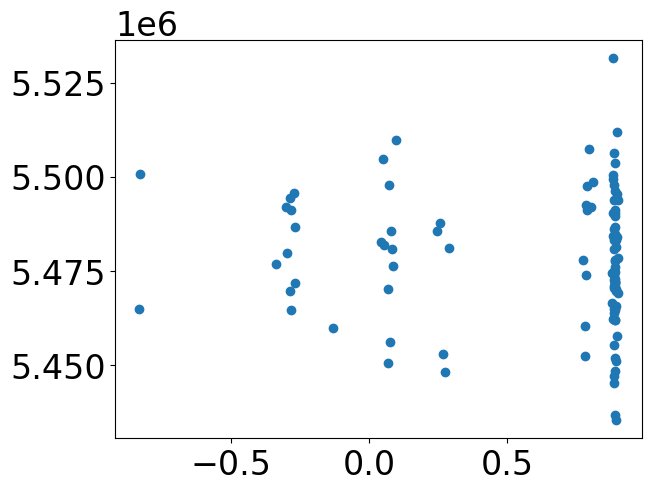

In [64]:
corrs_b = []
AICs = []

for bootstrap_idx,traj in bootstraps:
    ref_t = right_t[bootstrap_idx]
    t_hat = traj.Q.sum(1) @ traj.t
    corrs_b.append(stats.pearsonr(ref_t,t_hat)[0])
    AICs.append( traj.compute_AIC(traj.X, standard=True) )  
    
plt.plot(corrs_b,AICs,'.');

# Slingshot + tradeSeq

In [5]:
import rpy2
import rpy2.robjects as robjects

In [6]:
%load_ext rpy2.ipython

In [7]:
%%R 

library(tradeSeq, quietly = TRUE)
library(RColorBrewer, quietly = TRUE)
library(SingleCellExperiment, quietly = TRUE)
library(slingshot, quietly = TRUE)
library(umap, quietly = TRUE)
library(scran, quietly = TRUE)
library(scater, quietly = TRUE)
library(scuttle, quietly = TRUE)
library(Seurat, quietly = TRUE)
library(mclust, quietly = TRUE)

R[write to console]: 
Attaching package: ‘MatrixGenerics’


R[write to console]: The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges, rowRanks,
    rowSdDiffs, rowSds, rowSums2, rowTabulates, rowVarDiffs, rowVars,
    r


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

R[write to console]: 
Attaching package: ‘scran’


R[write to console]: The following object is masked from ‘package:TrajectoryUtils’:

    createClusterMST


R[write to console]: Attaching SeuratObject

R[write to console]: ‘SeuratObject’ was built under R 4.3.1 but the current version is
4.3.3; it is recomended that you reinstall ‘SeuratObject’ as the ABI
for R may have changed

R[write to console]: Seurat v4 was just loaded with SeuratObject v5; disabling v5 assays and
validation routines, and ensuring assays work in strict v3/v4
compatibility mode

R[write to console]: 
Attaching package: ‘Seurat’


R[write to console]: The following object is masked from ‘package:SummarizedExperiment’:

    Assays


R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



In [50]:
adata = sc.read('data/simulation_4_clusters.loom')
counts = adata.X.toarray().T
adata

/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 10000 × 200
    obs: 'cell_type', 'obs_names', 'read_depth', 'true_time'
    var: 'true_beta', 'true_gamma', 'var_names'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

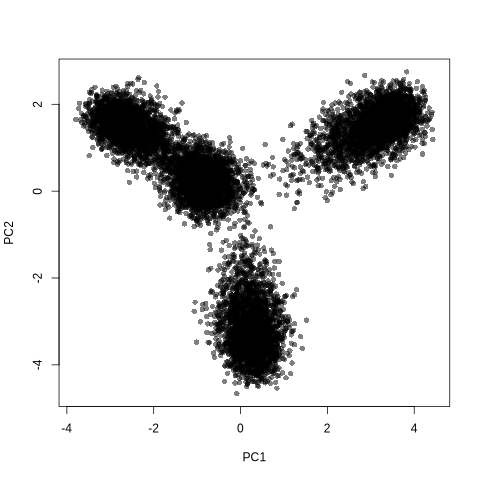

In [51]:
%%R -i counts

set.seed(42)
sce <- SingleCellExperiment(assays = list(counts = counts))
geneFilter <- apply(assays(sce)$counts,1,function(x){
    sum(x >= 3) >= 10
})
sce <- sce[geneFilter, ]

FQnorm <- function(counts){
    rk <- apply(counts,2,rank,ties.method='min')
    counts.sort <- apply(counts,2,sort)
    refdist <- apply(counts.sort,1,median)
    norm <- apply(rk,2,function(r){ refdist[r] })
    rownames(norm) <- rownames(counts)
    return(norm)
}
assays(sce)$norm <- FQnorm(assays(sce)$counts)

pca <- prcomp(t(log1p(assays(sce)$norm)), scale. = FALSE)
rd1 <- pca$x[,1:2]
reducedDims(sce) <- SimpleList(PCA = rd1)
plot(rd1, col = rgb(0,0,0,.5), pch=16, asp = 1)

fitting ...
  |======================================================================| 100%


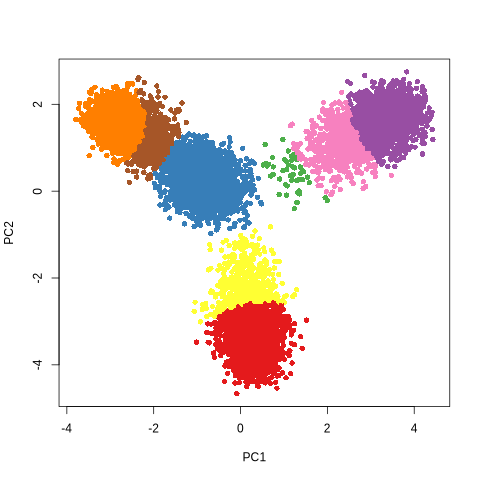

In [26]:
%%R
cl1 <- Mclust(rd1)$classification
colData(sce)$GMM <- cl1

library(RColorBrewer)
plot(rd1, col = brewer.pal(9,"Set1")[cl1], pch=16, asp = 1)

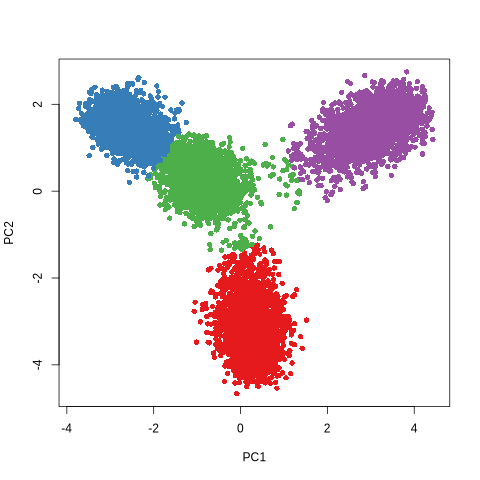

In [54]:
%%R
cl2 <- kmeans(rd1, centers = 4)$cluster
colData(sce)$kmeans <- cl2

plot(rd1, col = brewer.pal(9,"Set1")[cl2], pch=16, asp = 1)

## Set1: red blue green purple

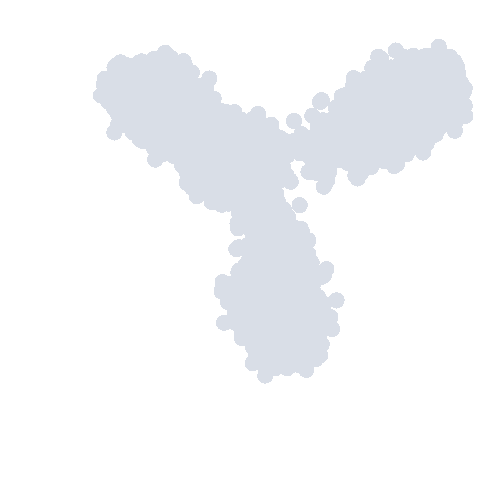

In [55]:
%%R
par(mar = c(4, 6, 0, 0))
plot(rd1, col='#d9dee7', axes=F, pch=16, asp=1, cex=3, cex.lab=3, xlab='', ylab='')

In [56]:
%%R
# slingshot with the true start cluster provided
sce <- slingshot(sce, clusterLabels = 'kmeans', reducedDim = 'PCA')
colData(sce)$slingshot

class: PseudotimeOrdering 
dim: 10000 2 
metadata(4): lineages mst slingParams curves
pathStats(2): pseudotime weights
cellnames(10000): Cell-1 Cell-2 ... Cell-9999 Cell-10000
cellData names(2): reducedDim clusterLabels
pathnames(2): Lineage1 Lineage2
pathData names(0):


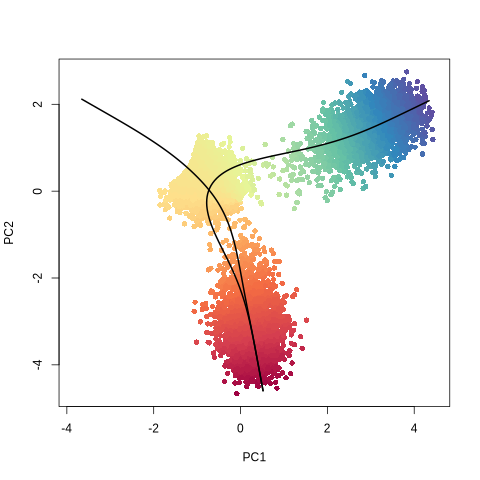

In [57]:
%%R
library(grDevices)
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plotcol <- colors[cut(sce$slingPseudotime_1, breaks=100)]

plot(reducedDims(sce)$PCA, col = plotcol, pch=16, asp = 1)
lines(SlingshotDataSet(sce), lwd=2, col='black')

In [58]:
%%R

#pdf('principle_curve.pdf')
par(mar = c(4, 6, 0, 0))

weights = slingCurveWeights(sce)
weight = weights/rowSums(weights)
time1 = sce$slingPseudotime_1
time1[is.na(time1)] = 0
time2 = sce$slingPseudotime_2
time2[is.na(time2)] = 0
x_pca = reducedDims(sce)$PCA

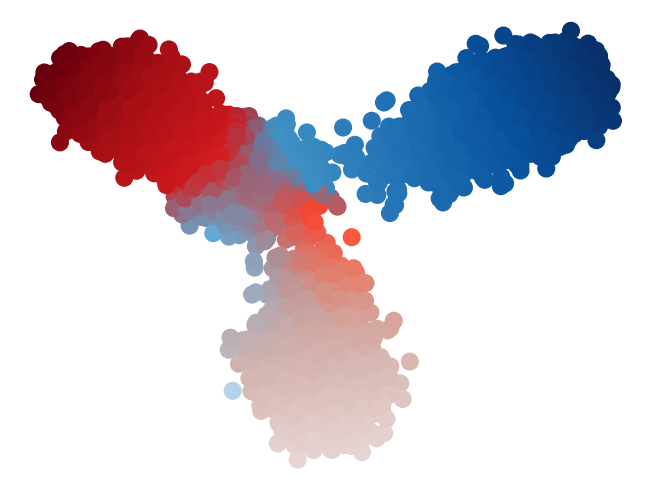

In [59]:
time1 = robjects.r['time1']
time2 = robjects.r['time2']
weight = np.array(robjects.r['weight'])
x_pca = np.array(robjects.r['x_pca'])
cmap_1 = cmr.get_sub_cmap('Blues', 0.2, 1)
cmap_2 = cmr.get_sub_cmap('Reds', 0.2, 1)

color_1 = weight[:,0,None]*np.array(cmap_1(time1/np.max(time1)))[:,:3]
color_2 = weight[:,1,None]*np.array(cmap_2(time2/np.max(time2)))[:,:3]
t_color = color_1 + color_2

plotcol = []
for (r,g,b) in t_color:
    plotcol.append('#%02x%02x%02x' % (int(r*255), int(g*255), int(b*255)))
    
fig, ax = plt.subplots(1,1)
im=ax.scatter(x_pca[:,0],x_pca[:,1],c=plotcol);
#ax.set_xlabel('PC1',fontsize=24)
#ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
#plt.colorbar(im,fraction=0.05, shrink=0.9) # adding the colobar on the right

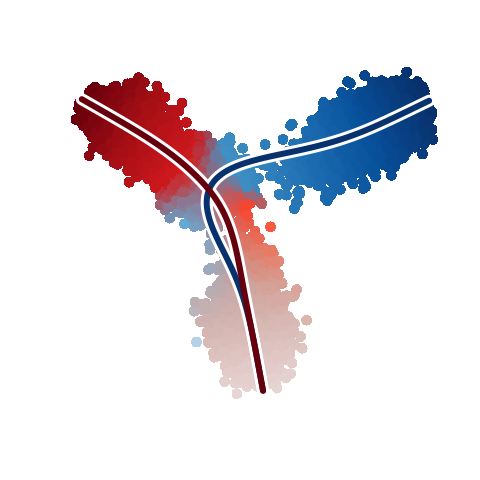

In [60]:
%%R -i plotcol

plot(reducedDims(sce)$PCA, col=plotcol, axes=F, pch=16, asp=1, cex=2, xlab='', ylab='')
#points(reducedDims(sce)$PCA, col=col2, pch=16, asp=1, cex=2)
lines(slingCurves(sce)[[1]], lwd=16, col = 'white')
lines(slingCurves(sce)[[2]], lwd=16, col = 'white')
lines(slingCurves(sce)[[1]], lwd=8, col = '#08326e')
lines(slingCurves(sce)[[2]], lwd=8, col = '#67000d')
#axis(side = 1)

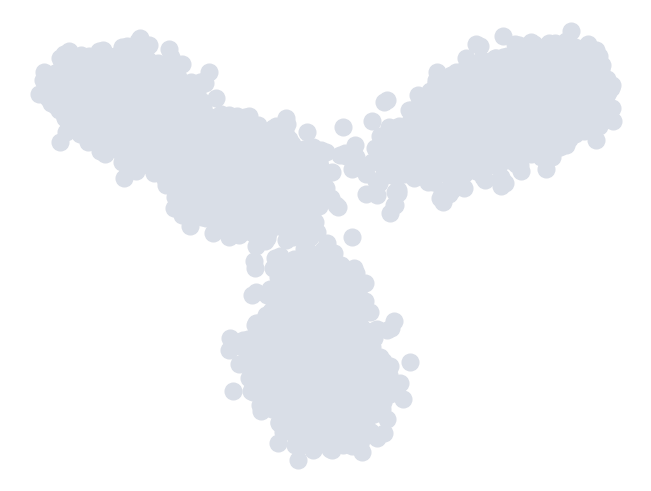

In [61]:
time1 = robjects.r['time1']
time2 = robjects.r['time2']
x_pca = np.array(robjects.r['x_pca'])

color_1 = weight[:,0,None]*np.array(cmap_1(time1/np.max(time1)))[:,:3]
color_2 = weight[:,1,None]*np.array(cmap_2(time2/np.max(time2)))[:,:3]
t_color = color_1 + color_2

fig, ax = plt.subplots(1,1)
im=ax.scatter(x_pca[:,0],x_pca[:,1],color='#d9dee7');
#ax.set_xlabel('PC1',fontsize=24)
#ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
#plt.colorbar(im,fraction=0.05, shrink=0.9) # adding the colobar on the right

In [42]:
%%R
# fit negative binomial GAM
sce <- fitGAM(sce)

# test for dynamic expression
ATres <- associationTest(sce)

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01m 27s       |++                                                | 2 % ~01m 59s       |++                                                | 3 % ~01m 45s       |+++                                               | 4 % ~01m 34s       |+++                                               | 5 % ~01m 30s       |++++                                              | 6 % ~01m 27s       |++++                                              | 7 % ~01m 25s       |+++++                                             | 8 % ~01m 31s       |+++++                                             | 9 % ~01m 28s       |++++++                                            | 10% ~01m 27s       |++++++                                            | 11% ~01m 24s       |+++++++                                           | 12% ~01m 23s       |+++++++                                           | 13% ~01m 

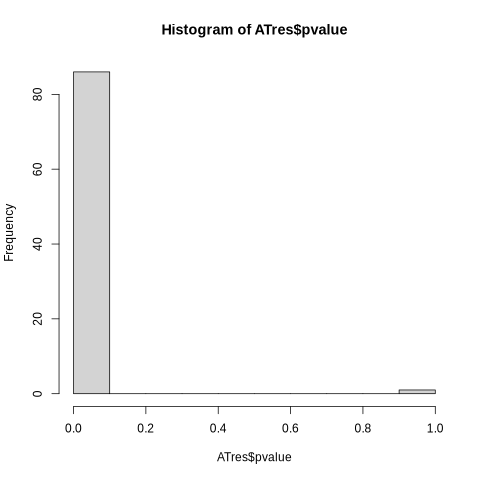

In [43]:
%%R
pvalue = ATres$pvalue
hist(ATres$pvalue)

 [1] "V1"  "V12" "V14" "V17" "V19" "V20" "V21" "V23" "V25" "V27"


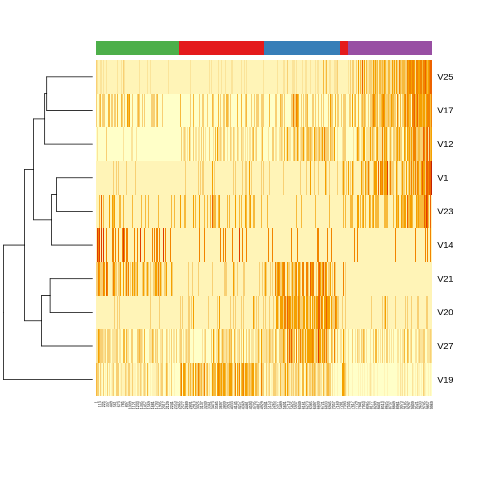

In [47]:
%%R
topgenes <- rownames(ATres[order(ATres$pvalue), ])[1:10]
pst.ord <- order(sce$slingPseudotime_1, na.last = NA)
heatdata <- assays(sce)$counts[topgenes, pst.ord]
heatclus <- sce$kmeans[pst.ord]

heatmap(log1p(heatdata), Colv = NA,
        ColSideColors = brewer.pal(9,"Set1")[heatclus])
topgenes

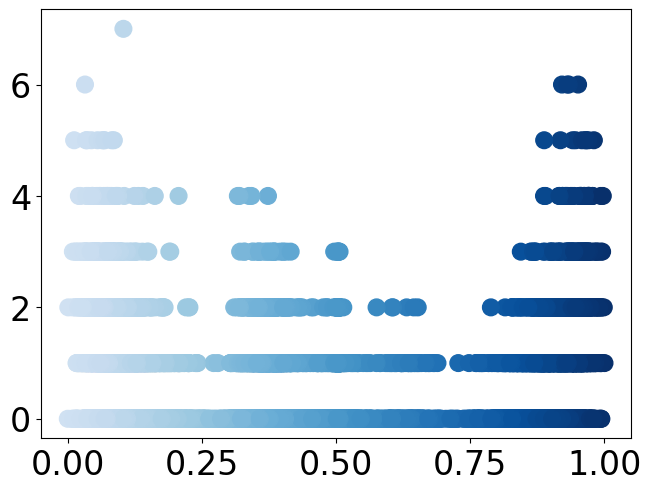

In [49]:
ptime = time1/np.max(time1) #weight[:,0]*time1/np.max(time1)+weight[:,1]*time2/np.max(time2)
color1 = cmap_1(time1/np.max(time1))
j = 1
plt.scatter(ptime,counts[j].flatten(),c=color1)

# DPT

We follow this [tutorial](https://scanpy.readthedocs.io/en/stable/tutorials/trajectories/paga-paul15.html)

In [64]:
adata = sc.read('data/simulation_4_clusters.loom')

/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [66]:
sc.pp.recipe_zheng17(adata,n_top_genes=200)
sc.tl.pca(adata, svd_solver="arpack")

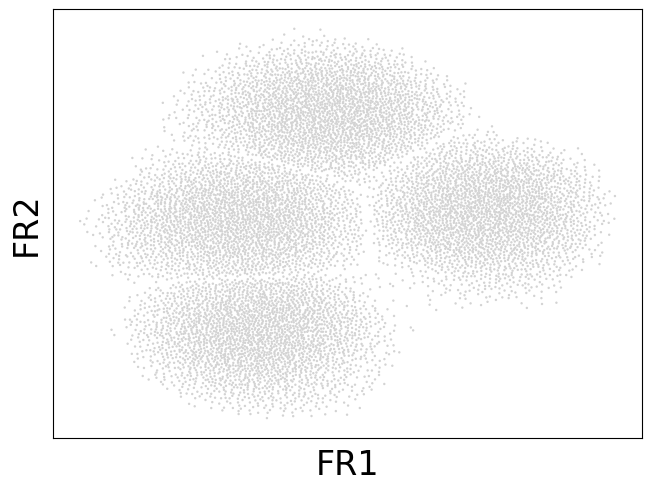

In [67]:
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
sc.tl.draw_graph(adata)

sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=10, use_rep="X_diffmap")
sc.pl.draw_graph(adata, legend_loc="on data")

In [68]:
sc.tl.leiden(adata)
sc.tl.paga(adata, groups="leiden")

In [69]:
adata.uns["iroot"] = 0
sc.tl.dpt(adata)

/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


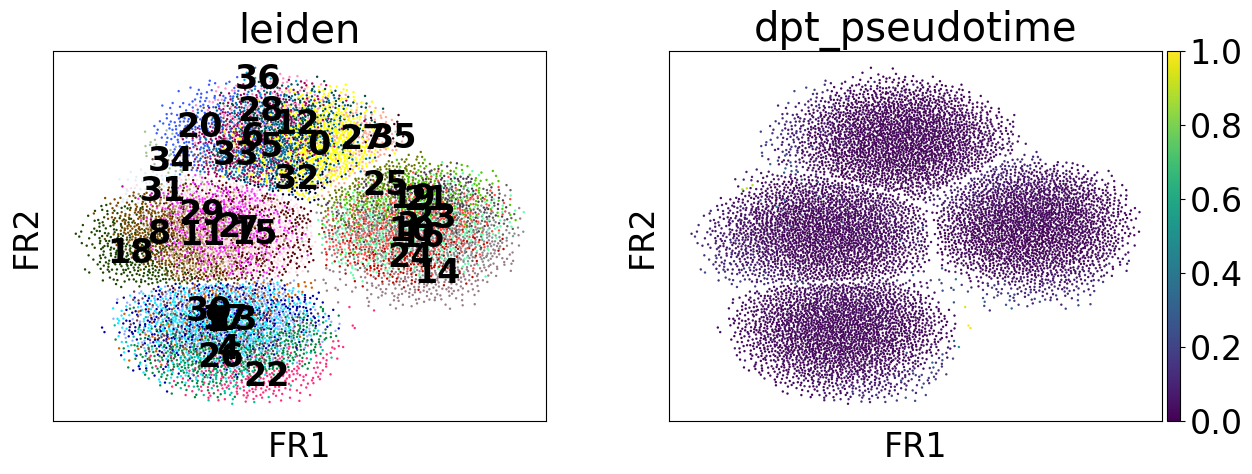

In [70]:
sc.pl.draw_graph(adata, color=["leiden", "dpt_pseudotime"], legend_loc="on data")

# VeloVI

https://velovi.readthedocs.io/en/latest/tutorial.html

In [4]:
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import torch
from velovi import preprocess_data, VELOVI

import matplotlib.pyplot as plt
import seaborn as sns

Global seed set to 0


In [6]:
adata = sc.read('data/simulation_4_clusters.loom',validate=False)
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=200)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 3 genes that are detected 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
Logarithmized X.


/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


computing neighbors
    finished (0:00:16) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [7]:
adata = preprocess_data(adata)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [8]:
sc.tl.umap(adata)

KeyboardInterrupt: 

In [ ]:
VELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
vae = VELOVI(adata)
vae.train()

In [ ]:
fig, ax = plt.subplots()
vae.history["elbo_train"].iloc[20:].plot(ax=ax, label="train")
vae.history["elbo_validation"].iloc[20:].plot(ax=ax, label="validation")
plt.legend()

In [ ]:
def add_velovi_outputs_to_adata(adata, vae):
    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_velovi"] = latent_time

    adata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    adata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    adata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    adata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var['fit_scaling'] = 1.0

add_velovi_outputs_to_adata(adata, vae)

In [ ]:
scv.tl.velocity_graph(adata)

In [ ]:
scv.pl.velocity_embedding_stream(adata, basis='umap')

In [ ]:
uncertainty_df, _ = vae.get_directional_uncertainty(n_samples=100)
uncertainty_df.head()

In [49]:
for c in uncertainty_df.columns:
    adata.obs[c] = np.log10(uncertainty_df[c].values)

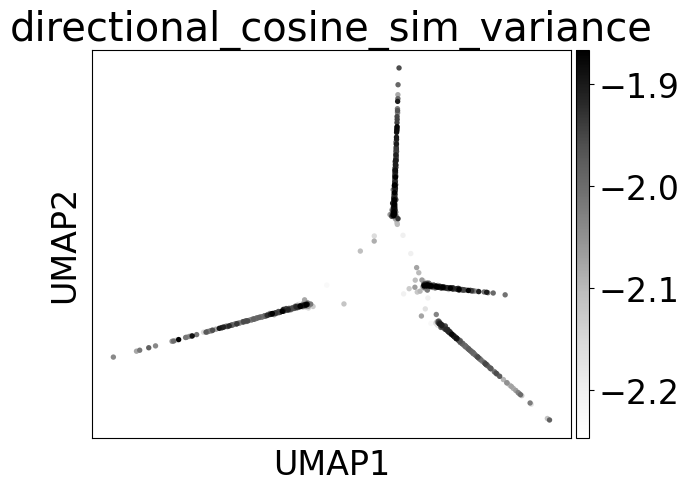

In [50]:
sc.pl.umap(
    adata, 
    color="directional_cosine_sim_variance",
    cmap="Greys",
    vmin="p1",
    vmax="p99",
)

In [51]:
def compute_extrinisic_uncertainty(adata, vae, n_samples=25) -> pd.DataFrame:
    from velovi._model import _compute_directional_statistics_tensor
    from scvi.utils import track
    from contextlib import redirect_stdout
    import io

    extrapolated_cells_list = []
    for i in track(range(n_samples)):
        with io.StringIO() as buf, redirect_stdout(buf):
            vkey = "velocities_velovi_{i}".format(i=i)
            v = vae.get_velocity(n_samples=1, velo_statistic="mean")
            adata.layers[vkey] = v
            scv.tl.velocity_graph(adata, vkey=vkey, sqrt_transform=False, approx=True)
            t_mat = scv.utils.get_transition_matrix(
                adata, vkey=vkey, self_transitions=True, use_negative_cosines=True
            )
            extrapolated_cells = np.asarray(t_mat @ adata.layers["Ms"])
            extrapolated_cells_list.append(extrapolated_cells)
    extrapolated_cells = np.stack(extrapolated_cells_list)
    df = _compute_directional_statistics_tensor(extrapolated_cells, n_jobs=-1, n_cells=adata.n_obs)
    return df

In [52]:
ext_uncertainty_df = compute_extrinisic_uncertainty(adata, vae)

Working...:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?cells/s]

Working...:   4%|▍         | 1/25 [00:02<00:55,  2.30s/it]

  0%|          | 0/2000 [00:00<?, ?cells/s]

Working...:   8%|▊         | 2/25 [00:04<00:56,  2.48s/it]

  0%|          | 0/2000 [00:00<?, ?cells/s]

Working...:  12%|█▏        | 3/25 [00:06<00:50,  2.30s/it]

  0%|          | 0/2000 [00:00<?, ?cells/s]

Working...:  16%|█▌        | 4/25 [00:09<00:49,  2.34s/it]

  0%|          | 0/2000 [00:00<?, ?cells/s]

Working...:  20%|██        | 5/25 [00:11<00:47,  2.36s/it]

  0%|          | 0/2000 [00:00<?, ?cells/s]

Working...:  24%|██▍       | 6/25 [00:13<00:43,  2.30s/it]

  0%|          | 0/2000 [00:00<?, ?cells/s]

Working...:  28%|██▊       | 7/25 [00:16<00:44,  2.47s/it]

  0%|          | 0/2000 [00:00<?, ?cells/s]

Working...:  32%|███▏      | 8/25 [00:19<00:42,  2.51s/it]

  0%|          | 0/2000 [00:00<?, ?cells/s]

Working...:  36%|███▌      | 9/25 [00:22<00:44,  2.77s/it]

  0%|          | 0/2000 [00:00<?, ?cells/s]

Working...:  40%|████      | 10/25 [00:25<00:39,  2.63s/it]

  0%|          | 0/2000 [00:00<?, ?cells/s]

Working...:  44%|████▍     | 11/25 [00:27<00:35,  2.51s/it]

  0%|          | 0/2000 [00:00<?, ?cells/s]

Working...:  48%|████▊     | 12/25 [00:29<00:31,  2.45s/it]

  0%|          | 0/2000 [00:00<?, ?cells/s]

Working...:  52%|█████▏    | 13/25 [00:32<00:29,  2.46s/it]

  0%|          | 0/2000 [00:00<?, ?cells/s]

Working...:  56%|█████▌    | 14/25 [00:34<00:26,  2.45s/it]

  0%|          | 0/2000 [00:00<?, ?cells/s]

Working...:  60%|██████    | 15/25 [00:36<00:23,  2.38s/it]

  0%|          | 0/2000 [00:00<?, ?cells/s]

Working...:  64%|██████▍   | 16/25 [00:38<00:20,  2.33s/it]

  0%|          | 0/2000 [00:00<?, ?cells/s]

Working...:  68%|██████▊   | 17/25 [00:41<00:18,  2.36s/it]

  0%|          | 0/2000 [00:00<?, ?cells/s]

Working...:  72%|███████▏  | 18/25 [00:44<00:17,  2.48s/it]

  0%|          | 0/2000 [00:00<?, ?cells/s]

Working...:  76%|███████▌  | 19/25 [00:46<00:15,  2.53s/it]

  0%|          | 0/2000 [00:00<?, ?cells/s]

Working...:  80%|████████  | 20/25 [00:49<00:12,  2.46s/it]

  0%|          | 0/2000 [00:00<?, ?cells/s]

Working...:  84%|████████▍ | 21/25 [00:51<00:09,  2.44s/it]

  0%|          | 0/2000 [00:00<?, ?cells/s]

Working...:  88%|████████▊ | 22/25 [00:53<00:07,  2.45s/it]

  0%|          | 0/2000 [00:00<?, ?cells/s]

Working...:  92%|█████████▏| 23/25 [00:56<00:04,  2.39s/it]

  0%|          | 0/2000 [00:00<?, ?cells/s]

Working...:  96%|█████████▌| 24/25 [00:58<00:02,  2.32s/it]

  0%|          | 0/2000 [00:00<?, ?cells/s]

Working...: 100%|██████████| 25/25 [01:00<00:00,  2.42s/it]
INFO     velovi: Computing the uncertainties...                                              


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 498 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.9s finished


In [64]:
ext_uncertainty_df[0]

,directional_variance,directional_difference,directional_cosine_sim_variance,directional_cosine_sim_difference,directional_cosine_sim_mean
0,1.363967,2.757586,0.710319,1.948144,0.471617
1,1.548549,2.785741,0.800557,1.967179,0.297093
2,0.873515,2.779900,0.436408,1.951593,0.713632
3,1.299330,3.002388,0.597991,1.993729,0.609575
4,1.340454,2.861628,0.684048,1.978265,0.464693
...,...,...,...,...,...
1995,1.505703,2.744565,0.817422,1.959478,0.192308
1996,0.262539,1.230334,0.230539,1.136664,0.108247
1997,1.355782,2.644430,0.768246,1.935161,0.335801
1998,1.822874,2.910627,0.883450,1.984803,0.291308


In [66]:
for c in ext_uncertainty_df[0].columns:
    adata.obs[c + "_extrinisic"] = np.log10(ext_uncertainty_df[0][c].values)

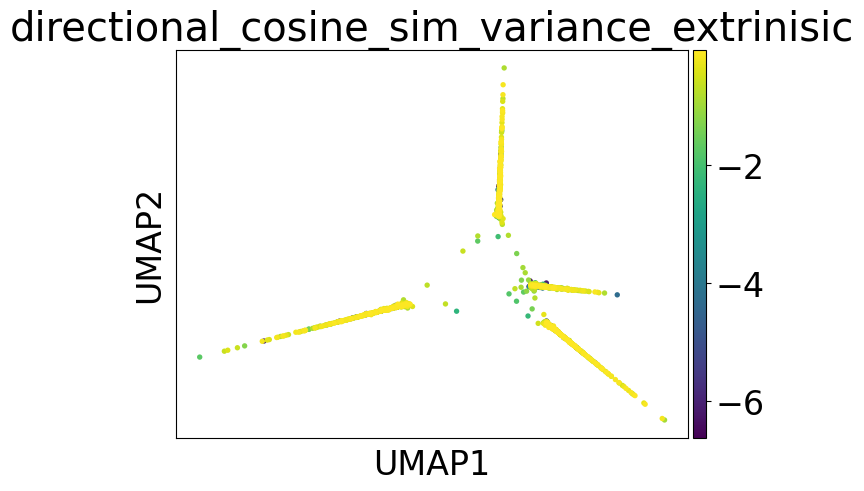

In [67]:
sc.pl.umap(
    adata, 
    color="directional_cosine_sim_variance_extrinisic",
    vmin="p1", 
    vmax="p99", 
)

In [69]:
adata.obs

,cell_type,obs_names,read_depth,true_time,initial_size_unspliced,initial_size_spliced,initial_size,n_counts,velocity_self_transition,directional_variance,...,velocities_velovi_20_self_transition,velocities_velovi_21_self_transition,velocities_velovi_22_self_transition,velocities_velovi_23_self_transition,velocities_velovi_24_self_transition,directional_variance_extrinisic,directional_difference_extrinisic,directional_cosine_sim_variance_extrinisic,directional_cosine_sim_difference_extrinisic,directional_cosine_sim_mean_extrinisic
0,0,0,0.226208,0,16,83,83.0,69.000000,0.186694,-1.888328,...,0.197616,0.188670,0.143338,0.181182,0.130832,0.134804,0.440529,-0.148546,0.289621,-0.326411
1,1,1,0.307276,1,25,111,111.0,68.378380,0.412496,-1.948899,...,0.285397,0.300326,0.247038,0.219285,0.373748,0.189925,0.444941,-0.096608,0.293844,-0.527108
2,3,2,0.142081,3,8,33,33.0,69.000000,0.048260,-1.967327,...,0.116702,0.008054,0.077976,0.056351,0.064527,-0.058730,0.444029,-0.360107,0.290389,-0.146526
3,1,3,0.180101,1,11,80,80.0,69.000000,0.246732,-1.895576,...,0.291133,0.242883,0.295693,0.253985,0.233738,0.113719,0.477467,-0.223306,0.299666,-0.214973
4,2,4,0.240857,2,16,64,64.0,67.921875,0.350664,-1.810966,...,0.353538,0.219414,0.259479,0.190227,0.241797,0.127252,0.456613,-0.164914,0.296284,-0.332834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,2,1995,0.209692,2,14,57,57.0,68.999992,0.262086,-1.805163,...,0.163717,0.212524,0.167237,0.017607,0.272784,0.177739,0.438474,-0.087554,0.292140,-0.716002
1996,0,1996,0.414688,0,29,141,141.0,69.000000,0.242791,-1.851052,...,0.209964,0.234120,0.239554,0.117632,0.160666,-0.580807,0.090023,-0.637255,0.055632,-0.965584
1997,3,1997,0.232494,3,13,73,73.0,69.000000,0.305540,-2.043661,...,0.109873,0.243686,0.337855,0.292980,0.258565,0.132190,0.422332,-0.114500,0.286717,-0.473918
1998,1,1998,0.139257,1,8,51,51.0,67.647057,0.324628,-1.724575,...,0.356751,0.132724,0.232432,0.269327,0.270050,0.260757,0.463987,-0.053818,0.297717,-0.535647


In [70]:
perm_df, _ = vae.get_permutation_scores(labels_key="cell_type")
adata.var["permutation_score"] = perm_df.max(1).values

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       


<AxesSubplot:xlabel='permutation_score', ylabel='Density'>

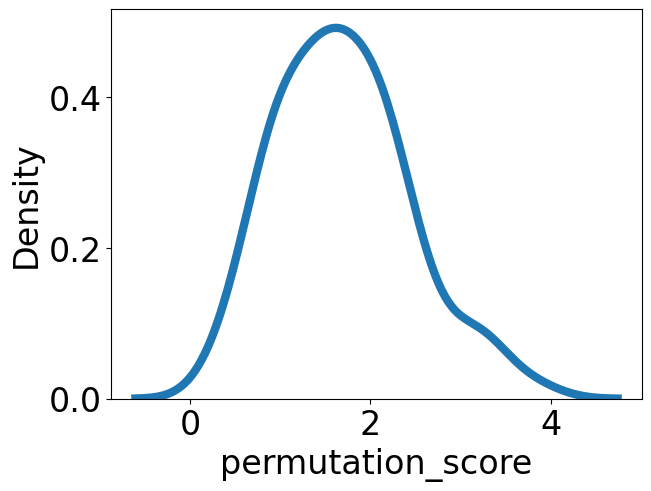

In [71]:
sns.kdeplot(data=adata.var, x="permutation_score")

## velocyto

https://github.com/velocyto-team/velocyto-notebooks/blob/master/python/hgForebrainGlutamatergic.ipynb

In [ ]:
from sklearn.manifold import TSNE
from umap import UMAP

def run_velocyto(loomfile,quiver_scale="auto"):
    vlm = vcy.VelocytoLoom(loomfile)
    # Preliminary Filtering
    vlm.filter_cells(bool_array=vlm.initial_Ucell_size > np.percentile(vlm.initial_Ucell_size, 0.5))
    vlm.set_clusters(vlm.ca["cell_type"])
    #vlm.score_detection_levels(min_expr_counts=40, min_cells_express=30)
    #vlm.filter_genes(by_detection_levels=True)
    #vlm.score_cv_vs_mean(100, plot=False, max_expr_avg=35)
    #vlm.filter_genes(by_cv_vs_mean=True)
    vlm._normalize_S(relative_size=vlm.S.sum(0),
                 target_size=vlm.S.sum(0).mean())
    vlm._normalize_U(relative_size=vlm.U.sum(0),
                 target_size=vlm.U.sum(0).mean())
    # Preparation for gamma fit
    vlm.perform_PCA()
    vlm.knn_imputation(n_pca_dims=20)
    # Gamma fit and extrapolation
    vlm.normalize_median()
    vlm.fit_gammas(maxmin_perc=[2,95], limit_gamma=True)
    vlm.normalize(which="imputed", size=False, log=True)
    vlm.Pcs = np.array(vlm.pcs[:,:2], order="C")
    vlm.predict_U()
    vlm.calculate_velocity()
    vlm.calculate_shift(assumption="constant_velocity")
    vlm.extrapolate_cell_at_t(delta_t=1.)
    # Projection of velocity onto embeddings
    #vlm.ts = TSNE().fit_transform(vlm.pcs[:, :25])
    vlm.estimate_transition_prob(hidim="Sx_sz", embed="Pcs", transform="sqrt", knn_random=True, sampled_fraction=0.5)
    vlm.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=True)
    vlm.calculate_grid_arrows(smooth=0.5, steps=(25, 25))

    #vlm.colorandum = vlm.ca["time"]
    vlm.plot_grid_arrows(quiver_scale=quiver_scale,plot_random=True)
    
    #fig = plt.figure()
    #plt.plot(vlm.ra["true_gamma"]/vlm.ra["true_beta"],vlm.gammas,'.');
    #plt.plot(vlm.ra["true_gamma"]/vlm.ra["true_beta"],vlm.ra["true_gamma"]/vlm.ra["true_beta"],'r-');
    #plt.xscale('log')
    #plt.yscale('log')
    return vlm

In [ ]:
vlm = run_velocyto("data/simulation_4_clusters.loom",quiver_scale=0.1)

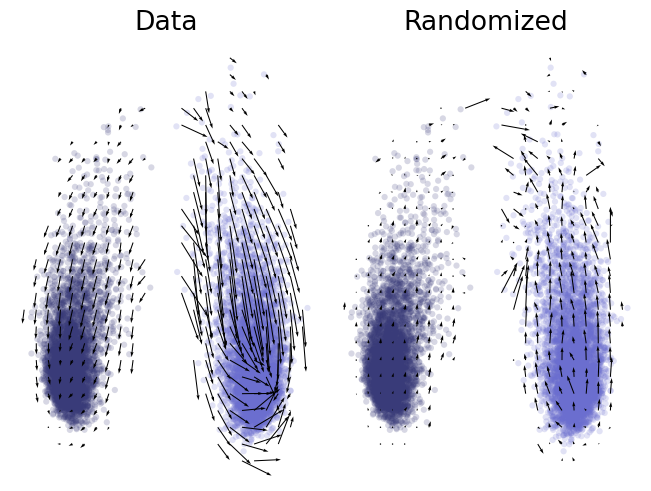

In [60]:
run_velocyto("data/simulation_2_clusters_noisy.loom",quiver_scale=0.1)

## cell2fate

In [8]:
import cell2fate as c2f

Global seed set to 0


AttributeError: module 'jax.tree_util' has no attribute 'register_pytree_with_keys_class'

In [ ]:
adata = sc.read('data/simulation_2_clusters_noisy.loom')
clusters_to_remove = []
adata = c2f.utils.get_training_data(adata, cells_per_cluster = 1000, cluster_column = 'cell_type',
                                    remove_clusters = clusters_to_remove,
                                min_shared_counts = 0, n_var_genes= 200)

## scvelo

https://scvelo.readthedocs.io/en/stable/DynamicalModeling/

In [1239]:
def run_scvelo(loomfile):
    adata = scv.read_loom(loomfile)
    scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=200)
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
    scv.tl.recover_dynamics(adata)
    scv.tl.velocity(adata)
    scv.tl.velocity(adata, mode='dynamical')
    scv.tl.velocity_graph(adata)
    scv.pl.velocity_embedding_stream(adata, basis='umap')
    scv.tl.latent_time(adata)
    scv.pl.scatter(adata, color='latent_time', color_map='gnuplot', size=80)
    top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index[:300]
    scv.pl.heatmap(adata, var_names=top_genes, sortby='latent_time', col_color='clusters', n_convolve=100)

    idx = adata.var['velocity_genes']
    if dynamical:
        true_gamma = adata.var['gamma']
        true_beta = adata.var['beta']
        betas = adata.var['fit_beta']
        gammas = adata.var['fit_gamma']
        fig, ax = plt.subplots(1,2,figsize=(12,4))
        ax[0].plot(true_beta[idx],betas[idx],'.');
        ax[0].plot(true_beta[idx],true_beta[idx],'r-');
        ax[1].plot(true_gamma[idx],gammas[idx],'.');
        ax[1].plot(true_gamma[idx],true_gamma[idx],'r-');
    else:
        true_gamma = adata.var['gamma']/adata.var['beta']
        gammas = adata.var['velocity_gamma']
        plt.plot(true_gamma[idx],gammas[idx],'.');
        plt.plot(true_gamma[idx],true_gamma[idx],'r-');
    
    plt.xscale('log')
    plt.yscale('log')
    return adata
  

In [1241]:
run_scvelo("data/simulation_clusters_1.loom")

Filtered out 2 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 200 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:16) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 1/88 cores)
The correlation threshold has been reduced to -0.2051.
Please be cautious when interpreting results.


  0%|          | 0/40 [00:00<?, ?gene/s]

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.

# CEM vs EM

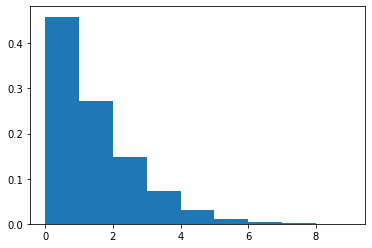

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

N=100000
c=0.2
z=np.random.uniform(0,10,size=N)
y=np.random.poisson(z)
x=np.random.poisson(c*y)
plt.hist(x,bins=np.arange(0,10),density=True);

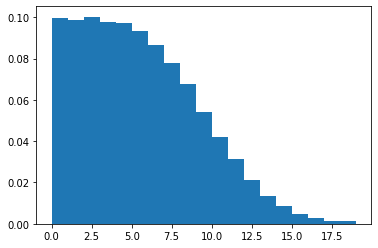

In [ ]:
plt.hist(y,bins=np.arange(0,20),density=True);

In [ ]:
def CEM_Q(theta,x):
    eps=1e-100
    h=np.linspace(0,theta,100)[None,:]
    ll=x[:,None]*np.log(h+eps)-h
    Q = np.mean(np.amax(ll,axis=1))
    return Q

In [ ]:
n=51
thetas = np.linspace(1,5,n)
Qs = np.zeros(n)
for i in range(n):
    Qs[i]=CEM_Q(thetas[i],x)

5.0


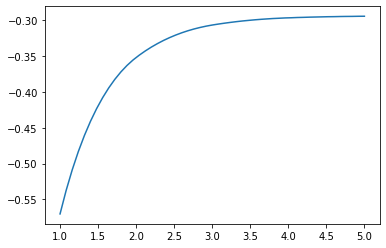

In [ ]:
plt.plot(thetas,Qs)
idx = np.argmax(Qs)
print(thetas[idx])

In [ ]:
from scipy.special import softmax

def EM_Q(theta,x):
    eps=1e-100
    h=np.linspace(0,theta,100)
    h=h[None,:]
    ll=x[:,None]*np.log(h+eps)-h
    q=softmax(ll,axis=1)
    Q=np.mean(np.sum(q*ll-q*np.log(q+eps),axis=1))
    return Q

In [ ]:
n=21
thetas = np.linspace(1.9,2.1,n)
Qs = np.zeros(n)
for i in range(n):
    Qs[i]=EM_Q(thetas[i],x)

2.0300000000000002


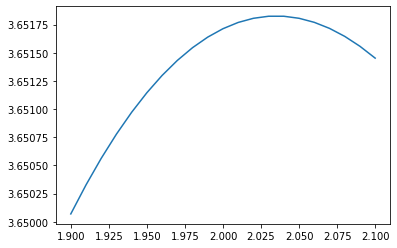

In [ ]:
plt.plot(thetas,Qs)
idx = np.argmax(Qs)
print(thetas[idx])

In [ ]:
n=21
thetas = np.linspace(9.9,10.1,n)
Qs = np.zeros(n)
for i in range(n):
    Qs[i]=EM_Q(thetas[i],y)

10.02


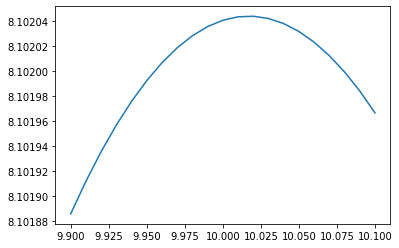

In [ ]:
plt.plot(thetas,Qs)
idx = np.argmax(Qs)
print(thetas[idx])

# Toggle switch

\begin{align}
&\frac{du_1}{dt} = \frac{\alpha_1}{1 + (s_3/k_1)^n} - \beta_1 u_1,\\[1em]
&\frac{ds_1}{dt} = \beta_1 u_1 - \gamma_1 s_1,\\[1em]
&\frac{du_2}{dt} = \frac{\alpha_2}{1 + (s_1/k_1)^n} - \beta_2 u_2,\\[1em]
&\frac{ds_2}{dt} = \beta_2 u_2 - \gamma_2 s_2,\\[1em]
&\frac{du_2}{dt} = \frac{\alpha_3}{1 + (s_3/k_1)^n} - \beta_3 u_3,\\[1em]
&\frac{ds_2}{dt} = \beta_3 u_3 - \gamma_2 s_3.
\end{align}

In [3]:
import numpy as np
from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt

In [43]:
def repressilator(t, y, alpha_1, alpha_2, alpha_3, beta_1, beta_2, beta_3, gamma_1, gamma_2, gamma_3, k, n): 
    u_1, s_1, u_2, s_2, u_3, s_3  = y
    du_1_dt = alpha_1/(1 + (s_3/k)**n) - beta_1 * u_1
    ds_1_dt = beta_1 * u_1 - gamma_1 * s_1
    du_2_dt = alpha_2/(1 + (s_1/k)**n) - beta_2 * u_2
    ds_2_dt = beta_2 * u_2 - gamma_2 * s_2
    du_3_dt = alpha_3/(1 + (s_1/k)**n) - beta_3 * u_3
    ds_3_dt = beta_3 * u_3 - gamma_3 * s_3

    return [du_1_dt, ds_1_dt, du_2_dt, ds_2_dt, du_3_dt, ds_3_dt]

In [72]:
def toggle_switch(t, y, alpha_1, alpha_2, beta_1, beta_2, gamma_1, gamma_2, k, n): 
    u_1, s_1, u_2, s_2 = y
    du_1_dt = alpha_1/(1 + (s_2/k)**n) - beta_1 * u_1
    ds_1_dt = beta_1 * u_1 - gamma_1 * s_1
    du_2_dt = alpha_2/(1 + (s_1/k)**n) - beta_2 * u_2
    ds_2_dt = beta_2 * u_2 - gamma_2 * s_2

    return [du_1_dt, ds_1_dt, du_2_dt, ds_2_dt]

In [18]:
def piecewise(t, y, alpha_1, alpha_2, beta_1, beta_2, gamma_1, gamma_2, k_1, k_2, n): 
    u_1, s_1, u_2, s_2 = y
    if t>0.03:
        alpha_1 = 0.032
    """ 
    if (s_2/k_1)**n > 1:
    alpha_1 = 0
    if (s_1/k_2)**n > 1:
    alpha_2 = 0
    """
    du_1_dt = alpha_1 - beta_1 * u_1
    ds_1_dt = beta_1 * u_1 - gamma_1 * s_1
    du_2_dt = alpha_2 - beta_2 * u_2
    ds_2_dt = beta_2 * u_2 - gamma_2 * s_2

    return [du_1_dt, ds_1_dt, du_2_dt, ds_2_dt]

In [73]:
# Parameters
alpha_1 = 100
alpha_2 = 100
alpha_3 = 100
beta_1 = 10
beta_2 = 10
beta_3 = 10
gamma_1 = 10
gamma_2 = 10
gamma_3 = 10
k = 4
n = 3

func_args = (alpha_1, alpha_2, alpha_3, beta_1, beta_2, beta_3, gamma_1, gamma_2, gamma_3, k, n)
func_args = (alpha_1, alpha_2, beta_1, beta_2, gamma_1, gamma_2, k, n)

In [74]:
T=1
n=1000
#sol_repressilator = solve_ivp(repressilator, [0, T], [10, 10, 0, 0, 5, 5], args=func_args, t_eval = np.linspace(0,T,n))
sol_toggle_switch = solve_ivp(toggle_switch, [0, T], [0, 0, 3, 3], args=func_args, t_eval = np.linspace(0,T,n))
#sol_piecewise = solve_ivp(piecewise, [0, T], [0, 0, 3, 3], args=func_args, t_eval = np.linspace(0,T,n))

"\nax[0].plot(sol_piecewise.y[0],sol_piecewise.y[2],'.');\nax[1].plot(sol_piecewise.y[0],sol_piecewise.y[1],'.');\nax[2].plot(sol_piecewise.y[2],sol_piecewise.y[3],'.');\n"

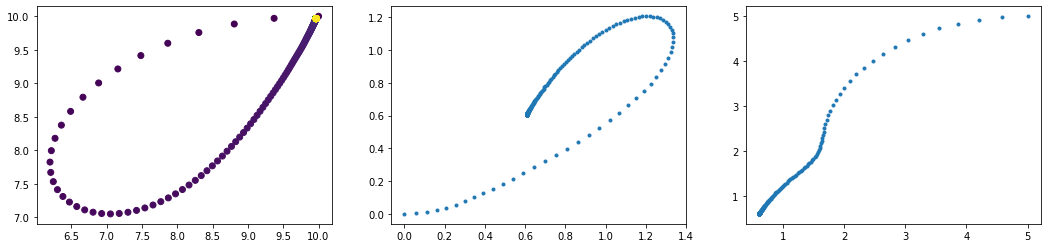

In [71]:
fig, ax = plt.subplots(1,3,figsize=(18,4))
ax[0].scatter(sol_repressilator.y[0],sol_repressilator.y[1],c=np.linspace(0,T,n));
ax[1].plot(sol_repressilator.y[2],sol_repressilator.y[3],'.');
ax[2].plot(sol_repressilator.y[4],sol_repressilator.y[5],'.');
"""
ax[0].plot(sol_piecewise.y[0],sol_piecewise.y[2],'.');
ax[1].plot(sol_piecewise.y[0],sol_piecewise.y[1],'.');
ax[2].plot(sol_piecewise.y[2],sol_piecewise.y[3],'.');
"""

"\nax[0].plot(sol_piecewise.y[0],sol_piecewise.y[2],'.');\nax[1].plot(sol_piecewise.y[0],sol_piecewise.y[1],'.');\nax[2].plot(sol_piecewise.y[2],sol_piecewise.y[3],'.');\n"

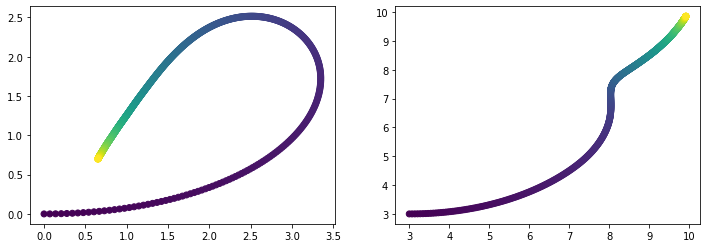

In [80]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(sol_toggle_switch.y[0],sol_toggle_switch.y[1],c=np.linspace(0,T,n));
ax[1].scatter(sol_toggle_switch.y[2],sol_toggle_switch.y[3],c=np.linspace(0,T,n));
"""
ax[0].plot(sol_piecewise.y[0],sol_piecewise.y[2],'.');
ax[1].plot(sol_piecewise.y[0],sol_piecewise.y[1],'.');
ax[2].plot(sol_piecewise.y[2],sol_piecewise.y[3],'.');
"""

In [25]:
X=np.zeros((n,3,2))
X[:,0,:] = np.random.poisson(sol_repressilator.y[0:2,:].T)
X[:,1,:] = np.random.poisson(sol_repressilator.y[2:4,:].T)
X[:,2,:] = np.random.poisson(sol_repressilator.y[4:,:].T)

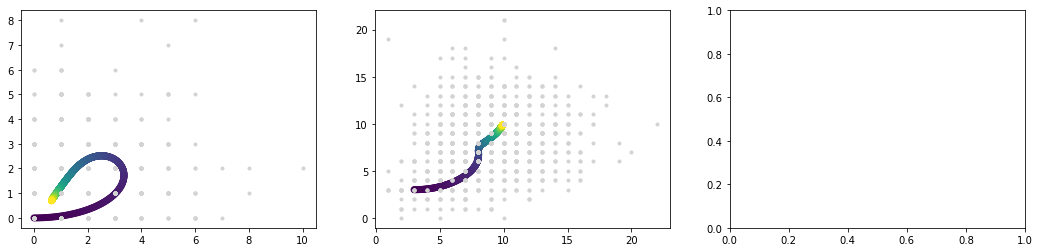

In [83]:
X=np.zeros((n,2,2))
X[:,0,:] = np.random.poisson(sol_toggle_switch.y[0:2,:].T)
X[:,1,:] = np.random.poisson(sol_toggle_switch.y[2:4,:].T)

fig, ax = plt.subplots(1,3,figsize=(18,4))
ax[0].scatter(sol_toggle_switch.y[0],sol_toggle_switch.y[1],c=np.linspace(0,T,n));
ax[1].scatter(sol_toggle_switch.y[2],sol_toggle_switch.y[3],c=np.linspace(0,T,n));


ax[0].plot(X[:,0,0],X[:,0,1],'.',color='lightgray');
ax[1].plot(X[:,1,0],X[:,1,1],'.',color='lightgray');


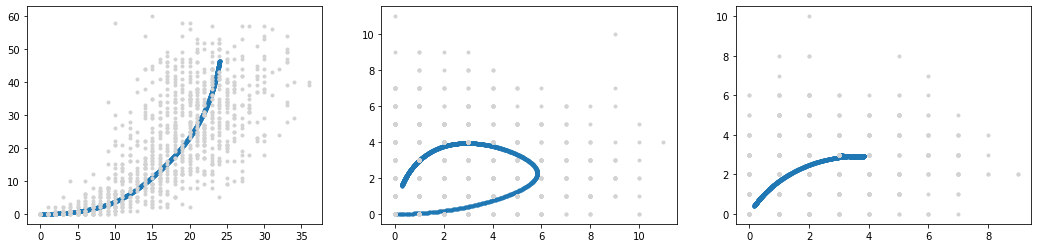

In [26]:
fig, ax = plt.subplots(1,3,figsize=(18,4))
ax[0].plot(sol_repressilator.y[0],sol_repressilator.y[1],'.');
ax[1].plot(sol_repressilator.y[2],sol_repressilator.y[3],'.');
ax[2].plot(sol_repressilator.y[4],sol_repressilator.y[5],'.');

ax[0].plot(X[:,0,0],X[:,0,1],'.',color='lightgray');
ax[1].plot(X[:,1,0],X[:,1,1],'.',color='lightgray');
ax[2].plot(X[:,2,0],X[:,2,1],'.',color='lightgray');

In [ ]:
Y=np.zeros((n,2,2))
Y_=np.zeros((n,2,2))
Y[:,0,:] = sol_toggle_switch.y[0:2,:].T
Y[:,1,:] = sol_toggle_switch.y[2:,:].T
Y_[:,0,:] = sol_piecewise.y[0:2,:].T
Y_[:,1,:] = sol_piecewise.y[2:,:].T

In [ ]:
logL = np.sum(X*np.log(Y+1e-6)-Y)

In [ ]:
logL_ = np.sum(X*np.log(Y_+1e-6)-Y_)

In [ ]:
logL, logL_

(19345.1814616582, 13911.119512963363)

In [ ]:
for seed in range(10):
  np.random.seed(seed)
  X=np.zeros((n,2,2))
  X[:,0,:] = np.random.poisson(sol_toggle_switch.y[0:2,:].T)
  X[:,1,:] = np.random.poisson(sol_toggle_switch.y[2:,:].T)
  logL = np.sum(X*np.log(Y+1e-6)-Y)
  logL_ = np.sum(X*np.log(Y_+1e-6)-Y_)
  print(logL, logL-logL_)


18880.03571626807 5324.7042063090485
19724.00254796687 5387.765836425984
19336.116476591138 5456.129096193097
19305.694539013144 5396.7025164842125
19103.44532761584 5333.563512339071
20141.930441571225 5433.368832422024
19846.408754534918 5228.998521898915
19225.844159742093 5459.7499646718425
19235.319949735633 5410.745083105829
19578.211082575617 5464.637577697415


## Fit toggle switch with piecewise

In [115]:
Q0 = np.diag(np.ones(n))

In [118]:
topo = np.array([[0,1]])
tau = (0,1,2)
traj = Trajectory(topo, tau, model="two_species",verbose=1)
traj = traj.fit(X,Q=Q0[:,None],m=100,n_init=10,epoch=100,parallel=False,n_threads=1)

run method fit_warm_start


100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


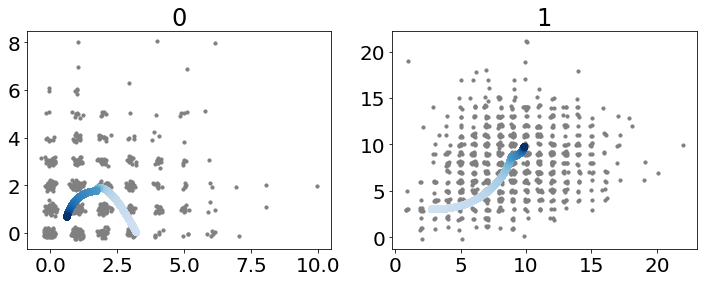

In [119]:
import matplotlib
matplotlib.rc('font', size=20)
fig, ax = plot_phase(traj,X=X,idx=np.arange(2))

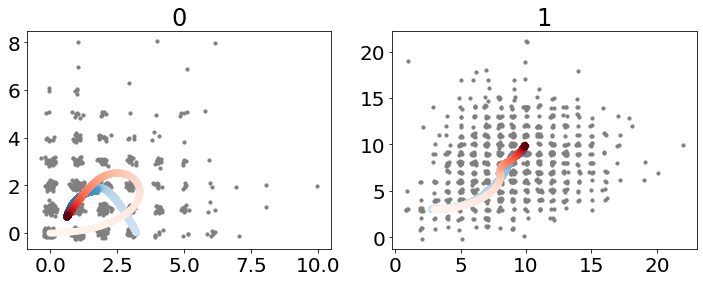

In [120]:
ax[0].scatter(sol_toggle_switch.y[0],sol_toggle_switch.y[1],c=np.linspace(0,T,n),cmap="Reds",alpha=1);
ax[1].scatter(sol_toggle_switch.y[2],sol_toggle_switch.y[3],c=np.linspace(0,T,n),cmap="Reds",alpha=1);
fig

<AxesSubplot:>

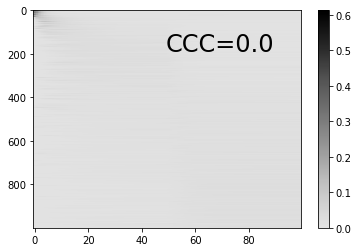

In [90]:
plot_t(traj,t=np.linspace(0,T,n))

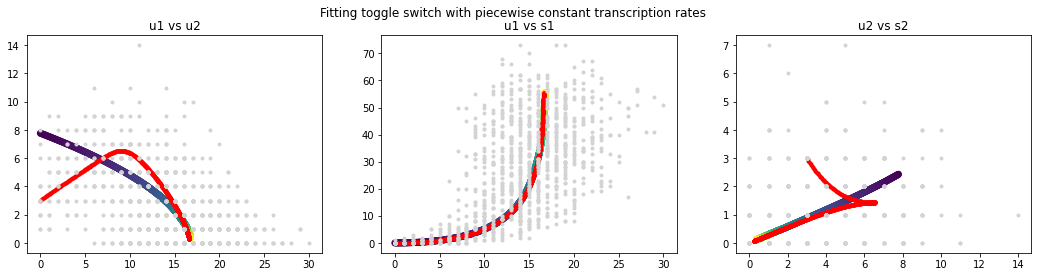

In [ ]:
t = traji.Q[:,0]@traji.t

fig, ax = plt.subplots(1,3,figsize=(18,4))
fig.suptitle("Fitting toggle switch with piecewise constant transcription rates")

ax[0].plot(sol_toggle_switch.y[0],sol_toggle_switch.y[2],'r.');
ax[0].set_title("u1 vs u2")
ax[1].plot(sol_toggle_switch.y[0],sol_toggle_switch.y[1],'r.');
ax[1].set_title("u1 vs s1")
ax[2].plot(sol_toggle_switch.y[2],sol_toggle_switch.y[3],'r.');
ax[2].set_title("u2 vs s2")

ax[0].plot(X[:,0,0],X[:,1,0],'.',color='lightgray');
ax[1].plot(X[:,0,0],X[:,0,1],'.',color='lightgray');
ax[2].plot(X[:,1,0],X[:,1,1],'.',color='lightgray');

ax[0].scatter(Y_fit[:,0,0],Y_fit[:,1,0],c=t);
ax[1].scatter(Y_fit[:,0,0],Y_fit[:,0,1],c=t);
ax[2].scatter(Y_fit[:,1,0],Y_fit[:,1,1],c=t);

In [ ]:
theta_hat

array([[16.52106173, 16.83319367,  0.        ,  0.        ,  5.82877743,
         0.93046774],
       [ 0.18237896,  0.        ,  7.77194007,  2.43075787,  3.11594158,
        13.72520698]])